In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
#import pyLDAvis.sklearn
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Shriprada\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
data = pd.read_csv("F:\\Project\\FILES\\review.csv")
data

Review  Rating
0      nice hotel expensive parking got good deal sta...       4
1      ok nothing special charge diamond member hilto...       2
2      nice rooms not 4* experience hotel monaco seat...       3
3      unique, great stay, wonderful time hotel monac...       5
4      great stay great stay, went seahawk game aweso...       5
...                                                  ...     ...
20486  best kept secret 3rd time staying charm, not 5...       5
20487  great location price view hotel great quick pl...       4
20488  ok just looks nice modern outside, desk staff ...       2
20489  hotel theft ruined vacation hotel opened sept ...       1
20490  people talking, ca n't believe excellent ratin...       2

[20491 rows x 2 columns]

In [3]:
data.isnull().sum()

Review    0
Rating    0
dtype: int64

In [4]:
data['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shriprada\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shriprada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
for index,text in enumerate(data['Review'][0:5]):
  print('\n Review %d:\n'%(index+1),text)


 Review 1:
 nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

 Review 2:
 ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room

In [7]:
data["is_bad_review"] = data["Rating"].apply(lambda x: 1 if x < 4 else 0)
data

Review  Rating  \
0      nice hotel expensive parking got good deal sta...       4   
1      ok nothing special charge diamond member hilto...       2   
2      nice rooms not 4* experience hotel monaco seat...       3   
3      unique, great stay, wonderful time hotel monac...       5   
4      great stay great stay, went seahawk game aweso...       5   
...                                                  ...     ...   
20486  best kept secret 3rd time staying charm, not 5...       5   
20487  great location price view hotel great quick pl...       4   
20488  ok just looks nice modern outside, desk staff ...       2   
20489  hotel theft ruined vacation hotel opened sept ...       1   
20490  people talking, ca n't believe excellent ratin...       2   

       is_bad_review  
0                  0  
1                  1  
2                  1  
3                  0  
4                  0  
...              ...  
20486              0  
20487              0  
20488              1  
20489              1  
20490              1  

[20491 rows x 3 columns]

In [8]:
data.is_bad_review.value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        1
2        1
3        0
4        0
        ..
20486    0
20487    0
20488    1
20489    1
20490    1
Name: is_bad_review, Length: 20491, dtype: int64>

In [9]:
import re

contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have", "n't": "not"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
data['Review']=data['Review'].apply(lambda x:expand_contractions(x))

In [10]:
data['cleaned']=data['Review'].apply(lambda x: x.lower())

In [11]:
data

Review  Rating  \
0      nice hotel expensive parking got good deal sta...       4   
1      ok nothing special charge diamond member hilto...       2   
2      nice rooms not 4* experience hotel monaco seat...       3   
3      unique, great stay, wonderful time hotel monac...       5   
4      great stay great stay, went seahawk game aweso...       5   
...                                                  ...     ...   
20486  best kept secret 3rd time staying charm, not 5...       5   
20487  great location price view hotel great quick pl...       4   
20488  ok just looks nice modern outside, desk staff ...       2   
20489  hotel theft ruined vacation hotel opened sept ...       1   
20490  people talking, ca not believe excellent ratin...       2   

       is_bad_review                                            cleaned  
0                  0  nice hotel expensive parking got good deal sta...  
1                  1  ok nothing special charge diamond member hilto...  
2                  1  nice rooms not 4* experience hotel monaco seat...  
3                  0  unique, great stay, wonderful time hotel monac...  
4                  0  great stay great stay, went seahawk game aweso...  
...              ...                                                ...  
20486              0  best kept secret 3rd time staying charm, not 5...  
20487              0  great location price view hotel great quick pl...  
20488              1  ok just looks nice modern outside, desk staff ...  
20489              1  hotel theft ruined vacation hotel opened sept ...  
20490              1  people talking, ca not believe excellent ratin...  

[20491 rows x 4 columns]

In [12]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

data['tokenized'] = data['cleaned'].apply(word_tokenize)
data.head()

Review  Rating  is_bad_review  \
0  nice hotel expensive parking got good deal sta...       4              0   
1  ok nothing special charge diamond member hilto...       2              1   
2  nice rooms not 4* experience hotel monaco seat...       3              1   
3  unique, great stay, wonderful time hotel monac...       5              0   
4  great stay great stay, went seahawk game aweso...       5              0   

                                             cleaned  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           tokenized  
0  [nice, hotel, expensive, parking, got, good, d...  
1  [ok, nothing, special, charge, diamond, member...  
2  [nice, rooms, not, 4, *, experience, hotel, mo...  
3  [unique, ,, great, stay, ,, wonderful, time, h...  
4  [great, stay, great, stay, ,, went, seahawk, g...

In [13]:
import string
punc = string.punctuation
data['no_punc'] = data['tokenized'].apply(lambda x: [word for word in x if word not in punc])
data.head()


Review  Rating  is_bad_review  \
0  nice hotel expensive parking got good deal sta...       4              0   
1  ok nothing special charge diamond member hilto...       2              1   
2  nice rooms not 4* experience hotel monaco seat...       3              1   
3  unique, great stay, wonderful time hotel monac...       5              0   
4  great stay great stay, went seahawk game aweso...       5              0   

                                             cleaned  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           tokenized  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, 4, *, experience, hotel, mo...   
3  [unique, ,, great, stay, ,, wonderful, time, h...   
4  [great, stay, great, stay, ,, went, seahawk, g...   

                                             no_punc  
0  [nice, hotel, expensive, parking, got, good, d...  
1  [ok, nothing, special, charge, diamond, member...  
2  [nice, rooms, not, 4, experience, hotel, monac...  
3  [unique, great, stay, wonderful, time, hotel, ...  
4  [great, stay, great, stay, went, seahawk, game...

In [14]:
stop_words = set(stopwords.words('english'))
data['stopwords_removed'] = data['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
data.head()

Review  Rating  is_bad_review  \
0  nice hotel expensive parking got good deal sta...       4              0   
1  ok nothing special charge diamond member hilto...       2              1   
2  nice rooms not 4* experience hotel monaco seat...       3              1   
3  unique, great stay, wonderful time hotel monac...       5              0   
4  great stay great stay, went seahawk game aweso...       5              0   

                                             cleaned  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           tokenized  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, 4, *, experience, hotel, mo...   
3  [unique, ,, great, stay, ,, wonderful, time, h...   
4  [great, stay, great, stay, ,, went, seahawk, g...   

                                             no_punc  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, 4, experience, hotel, monac...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                   stopwords_removed  
0  [nice, hotel, expensive, parking, got, good, d...  
1  [ok, nothing, special, charge, diamond, member...  
2  [nice, rooms, 4, experience, hotel, monaco, se...  
3  [unique, great, stay, wonderful, time, hotel, ...  
4  [great, stay, great, stay, went, seahawk, game...

In [15]:
data['pos_tags'] = data['stopwords_removed'].apply(nltk.tag.pos_tag)

In [16]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
data['wordnet_pos'] = data['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shriprada\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Shriprada\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Review  Rating  is_bad_review  \
0  nice hotel expensive parking got good deal sta...       4              0   
1  ok nothing special charge diamond member hilto...       2              1   
2  nice rooms not 4* experience hotel monaco seat...       3              1   
3  unique, great stay, wonderful time hotel monac...       5              0   
4  great stay great stay, went seahawk game aweso...       5              0   

                                             cleaned  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           tokenized  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, 4, *, experience, hotel, mo...   
3  [unique, ,, great, stay, ,, wonderful, time, h...   
4  [great, stay, great, stay, ,, went, seahawk, g...   

                                             no_punc  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, 4, experience, hotel, monac...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                   stopwords_removed  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, 4, experience, hotel, monaco, se...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                            pos_tags  \
0  [(nice, JJ), (hotel, NN), (expensive, JJ), (pa...   
1  [(ok, JJ), (nothing, NN), (special, JJ), (char...   
2  [(nice, JJ), (rooms, NNS), (4, CD), (experienc...   
3  [(unique, JJ), (great, JJ), (stay, NN), (wonde...   
4  [(great, JJ), (stay, NN), (great, JJ), (stay, ...   

                                         wordnet_pos  
0  [(nice, a), (hotel, n), (expensive, a), (parki...  
1  [(ok, a), (nothing, n), (special, a), (charge,...  
2  [(nice, a), (rooms, n), (4, n), (experience, n...  
3  [(unique, a), (great, a), (stay, n), (wonderfu...  
4  [(great, a), (stay, n), (great, a), (stay, n),...

In [17]:
wnl = WordNetLemmatizer()
data['lemmatized'] = data['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
data.head()

Review  Rating  is_bad_review  \
0  nice hotel expensive parking got good deal sta...       4              0   
1  ok nothing special charge diamond member hilto...       2              1   
2  nice rooms not 4* experience hotel monaco seat...       3              1   
3  unique, great stay, wonderful time hotel monac...       5              0   
4  great stay great stay, went seahawk game aweso...       5              0   

                                             cleaned  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                           tokenized  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, 4, *, experience, hotel, mo...   
3  [unique, ,, great, stay, ,, wonderful, time, h...   
4  [great, stay, great, stay, ,, went, seahawk, g...   

                                             no_punc  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, not, 4, experience, hotel, monac...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                   stopwords_removed  \
0  [nice, hotel, expensive, parking, got, good, d...   
1  [ok, nothing, special, charge, diamond, member...   
2  [nice, rooms, 4, experience, hotel, monaco, se...   
3  [unique, great, stay, wonderful, time, hotel, ...   
4  [great, stay, great, stay, went, seahawk, game...   

                                            pos_tags  \
0  [(nice, JJ), (hotel, NN), (expensive, JJ), (pa...   
1  [(ok, JJ), (nothing, NN), (special, JJ), (char...   
2  [(nice, JJ), (rooms, NNS), (4, CD), (experienc...   
3  [(unique, JJ), (great, JJ), (stay, NN), (wonde...   
4  [(great, JJ), (stay, NN), (great, JJ), (stay, ...   

                                         wordnet_pos  \
0  [(nice, a), (hotel, n), (expensive, a), (parki...   
1  [(ok, a), (nothing, n), (special, a), (charge,...   
2  [(nice, a), (rooms, n), (4, n), (experience, n...   
3  [(unique, a), (great, a), (stay, n), (wonderfu...   
4  [(great, a), (stay, n), (great, a), (stay, n),...   

                                          lemmatized  
0  [nice, hotel, expensive, parking, get, good, d...  
1  [ok, nothing, special, charge, diamond, member...  
2  [nice, room, 4, experience, hotel, monaco, sea...  
3  [unique, great, stay, wonderful, time, hotel, ...  
4  [great, stay, great, stay, go, seahawk, game, ...

In [18]:
data = data[['Rating', 'lemmatized']]
data.head()


Rating                                         lemmatized
0       4  [nice, hotel, expensive, parking, get, good, d...
1       2  [ok, nothing, special, charge, diamond, member...
2       3  [nice, room, 4, experience, hotel, monaco, sea...
3       5  [unique, great, stay, wonderful, time, hotel, ...
4       5  [great, stay, great, stay, go, seahawk, game, ...

In [19]:
data['lemma_str'] = [' '.join(map(str,l)) for l in data['lemmatized']]
data.head()

C:\Users\Shriprada\AppData\Local\Temp\ipykernel_2708\3556439588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lemma_str'] = [' '.join(map(str,l)) for l in data['lemmatized']]


Rating                                         lemmatized  \
0       4  [nice, hotel, expensive, parking, get, good, d...   
1       2  [ok, nothing, special, charge, diamond, member...   
2       3  [nice, room, 4, experience, hotel, monaco, sea...   
3       5  [unique, great, stay, wonderful, time, hotel, ...   
4       5  [great, stay, great, stay, go, seahawk, game, ...   

                                           lemma_str  
0  nice hotel expensive parking get good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice room 4 experience hotel monaco seattle go...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay go seahawk game awesome ...

In [20]:
!pip install textblob
!pip install afinn
import textblob
from textblob import TextBlob
from afinn import Afinn
from collections import Counter

#data['sentiment'] = data['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
#data.head()

afinn_sentiment = Afinn()
score = [afinn_sentiment.score(item) for item in data['lemma_str']]
Affin_sentiment = [1 if score > 0 else 0 for score in score]

data['Affin_score'] = score
data['Affin_sentiment'] = Affin_sentiment

data

C:\Users\Shriprada\AppData\Local\Temp\ipykernel_2708\863758058.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Affin_score'] = score
C:\Users\Shriprada\AppData\Local\Temp\ipykernel_2708\863758058.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Affin_sentiment'] = Affin_sentiment


Rating                                         lemmatized  \
0           4  [nice, hotel, expensive, parking, get, good, d...   
1           2  [ok, nothing, special, charge, diamond, member...   
2           3  [nice, room, 4, experience, hotel, monaco, sea...   
3           5  [unique, great, stay, wonderful, time, hotel, ...   
4           5  [great, stay, great, stay, go, seahawk, game, ...   
...       ...                                                ...   
20486       5  [best, keep, secret, 3rd, time, stay, charm, 5...   
20487       4  [great, location, price, view, hotel, great, q...   
20488       2  [ok, look, nice, modern, outside, desk, staff,...   
20489       1  [hotel, theft, ruin, vacation, hotel, open, se...   
20490       2  [people, talk, ca, believe, excellent, rating,...   

                                               lemma_str  Affin_score  \
0      nice hotel expensive parking get good deal sta...         26.0   
1      ok nothing special charge diamond member hilto...         36.0   
2      nice room 4 experience hotel monaco seattle go...         20.0   
3      unique great stay wonderful time hotel monaco ...         39.0   
4      great stay great stay go seahawk game awesome ...         37.0   
...                                                  ...          ...   
20486  best keep secret 3rd time stay charm 5-star ca...         23.0   
20487  great location price view hotel great quick pl...         21.0   
20488  ok look nice modern outside desk staff particu...          8.0   
20489  hotel theft ruin vacation hotel open sept 17 2...         -9.0   
20490  people talk ca believe excellent rating hotel ...         15.0   

       Affin_sentiment  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
20486                1  
20487                1  
20488                1  
20489                0  
20490                1  

[20491 rows x 5 columns]

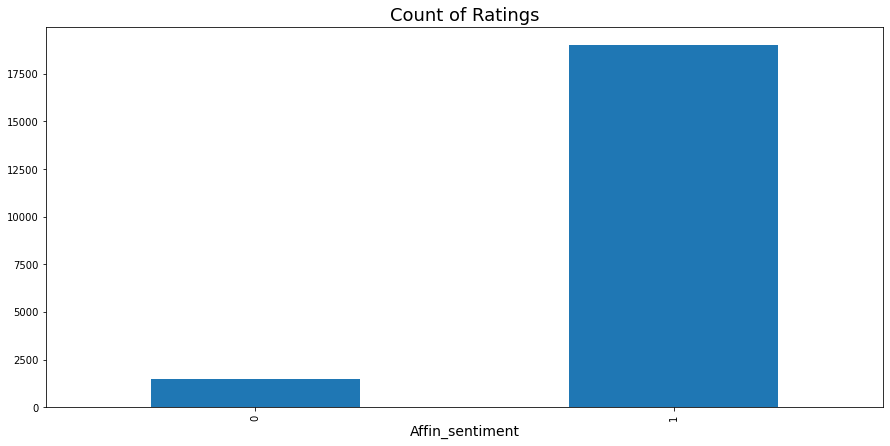

In [21]:
say = data["Affin_sentiment"].value_counts()
say.sort_index().plot(kind = "bar",figsize = (15,7))
plt.title("Count of Ratings",fontsize = 18)
plt.xlabel("Affin_sentiment",fontsize = 14)
plt.show()

C:\Users\Shriprada\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

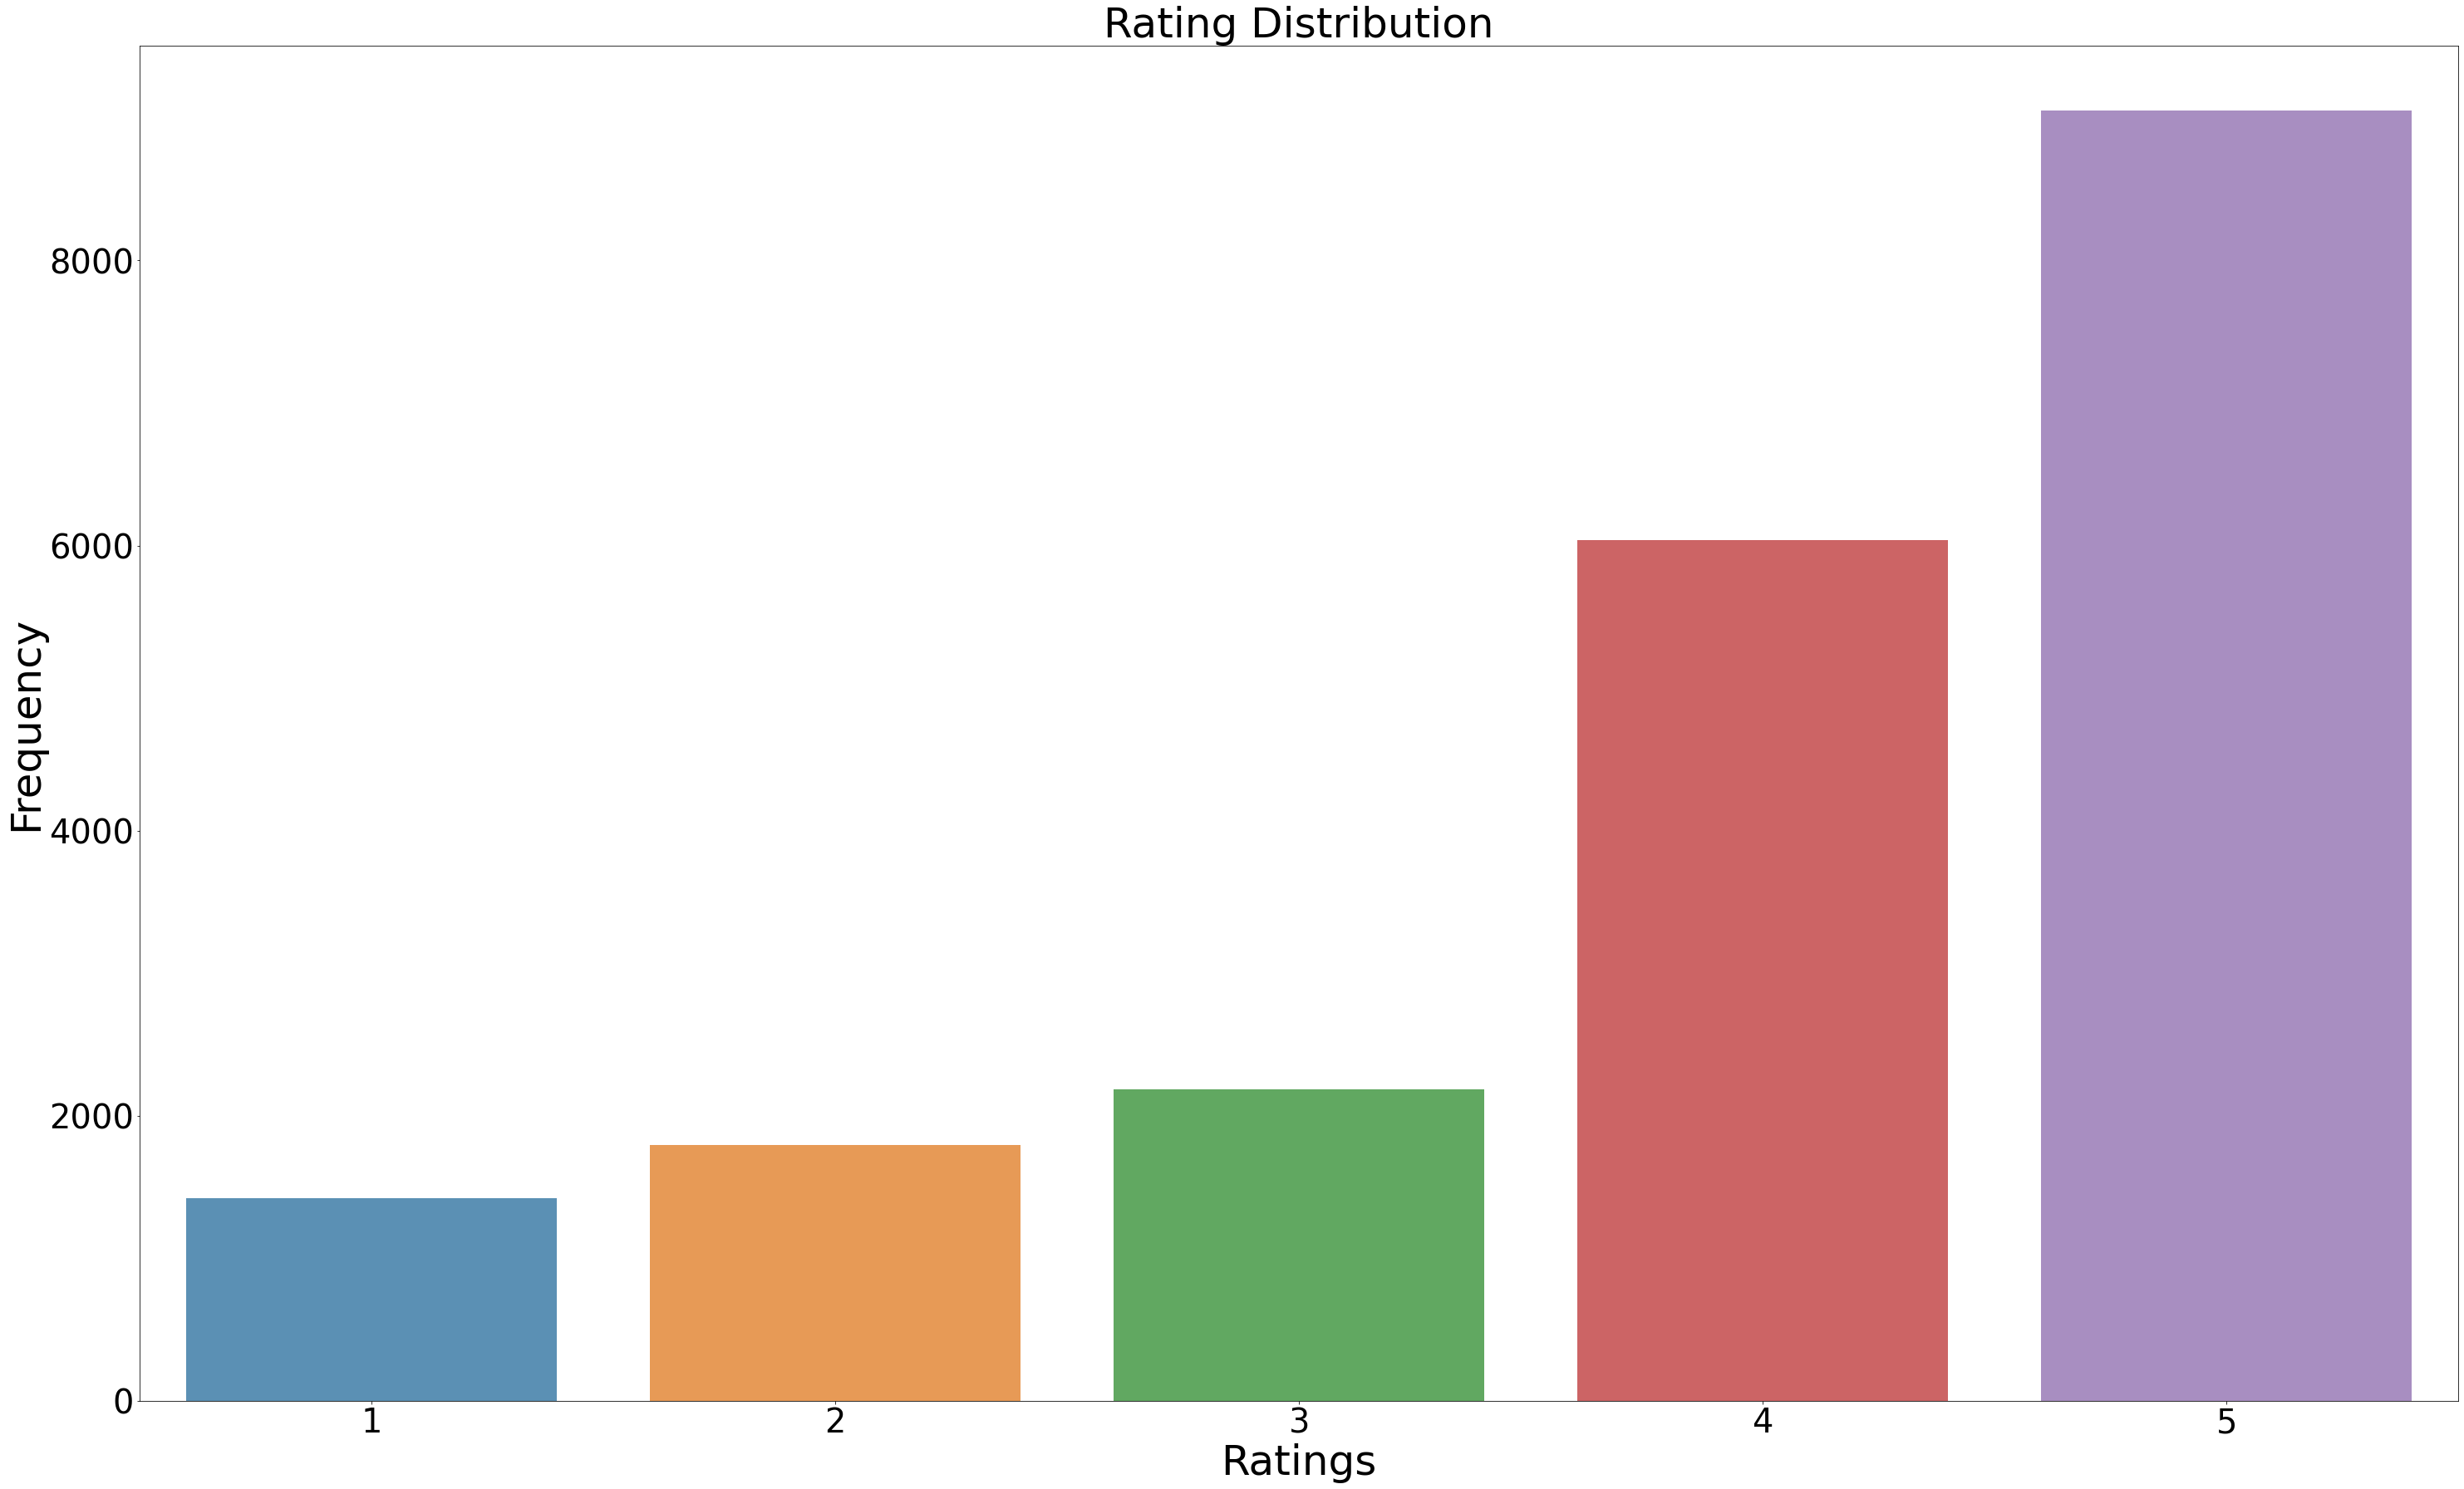

In [22]:
x_rating = data.Rating.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Ratings', fontsize=50)
plt.xticks(fontsize=40)

<AxesSubplot:title={'center':'Percentage of Ratings'}, ylabel='Rating'>

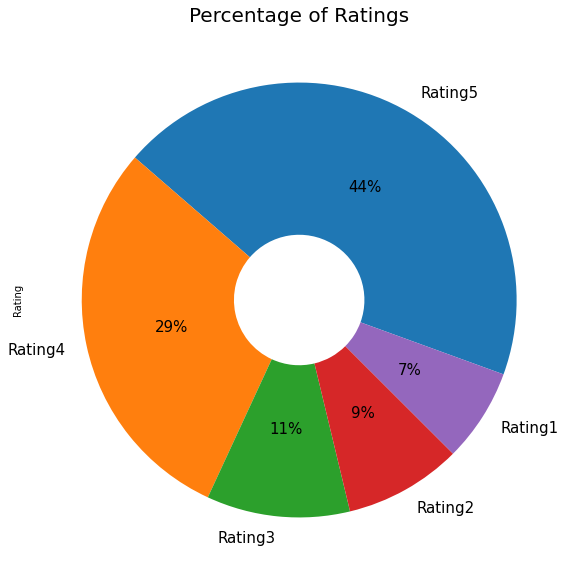

In [23]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Ratings', fontsize=20)
data.Rating.value_counts().plot(kind='pie', labels=['Rating5', 'Rating4', 'Rating3', 'Rating2', 'Rating1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

In [24]:
data['word_count'] = data['lemmatized'].apply(lambda x: len(str(x).split()))
data['review_len'] = data['lemma_str'].astype(str).apply(len)
data

C:\Users\Shriprada\AppData\Local\Temp\ipykernel_2708\777354194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word_count'] = data['lemmatized'].apply(lambda x: len(str(x).split()))
C:\Users\Shriprada\AppData\Local\Temp\ipykernel_2708\777354194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review_len'] = data['lemma_str'].astype(str).apply(len)


Rating                                         lemmatized  \
0           4  [nice, hotel, expensive, parking, get, good, d...   
1           2  [ok, nothing, special, charge, diamond, member...   
2           3  [nice, room, 4, experience, hotel, monaco, sea...   
3           5  [unique, great, stay, wonderful, time, hotel, ...   
4           5  [great, stay, great, stay, go, seahawk, game, ...   
...       ...                                                ...   
20486       5  [best, keep, secret, 3rd, time, stay, charm, 5...   
20487       4  [great, location, price, view, hotel, great, q...   
20488       2  [ok, look, nice, modern, outside, desk, staff,...   
20489       1  [hotel, theft, ruin, vacation, hotel, open, se...   
20490       2  [people, talk, ca, believe, excellent, rating,...   

                                               lemma_str  Affin_score  \
0      nice hotel expensive parking get good deal sta...         26.0   
1      ok nothing special charge diamond member hilto...         36.0   
2      nice room 4 experience hotel monaco seattle go...         20.0   
3      unique great stay wonderful time hotel monaco ...         39.0   
4      great stay great stay go seahawk game awesome ...         37.0   
...                                                  ...          ...   
20486  best keep secret 3rd time stay charm 5-star ca...         23.0   
20487  great location price view hotel great quick pl...         21.0   
20488  ok look nice modern outside desk staff particu...          8.0   
20489  hotel theft ruin vacation hotel open sept 17 2...         -9.0   
20490  people talk ca believe excellent rating hotel ...         15.0   

       Affin_sentiment  word_count  review_len  
0                    1          81         523  
1                    1         237        1551  
2                    1         205        1313  
3                    1          84         541  
4                    1         174        1093  
...                ...         ...         ...  
20486                1         105         663  
20487                1          39         297  
20488                1          60         402  
20489                0         740        5048  
20490                1          83         548  

[20491 rows x 7 columns]

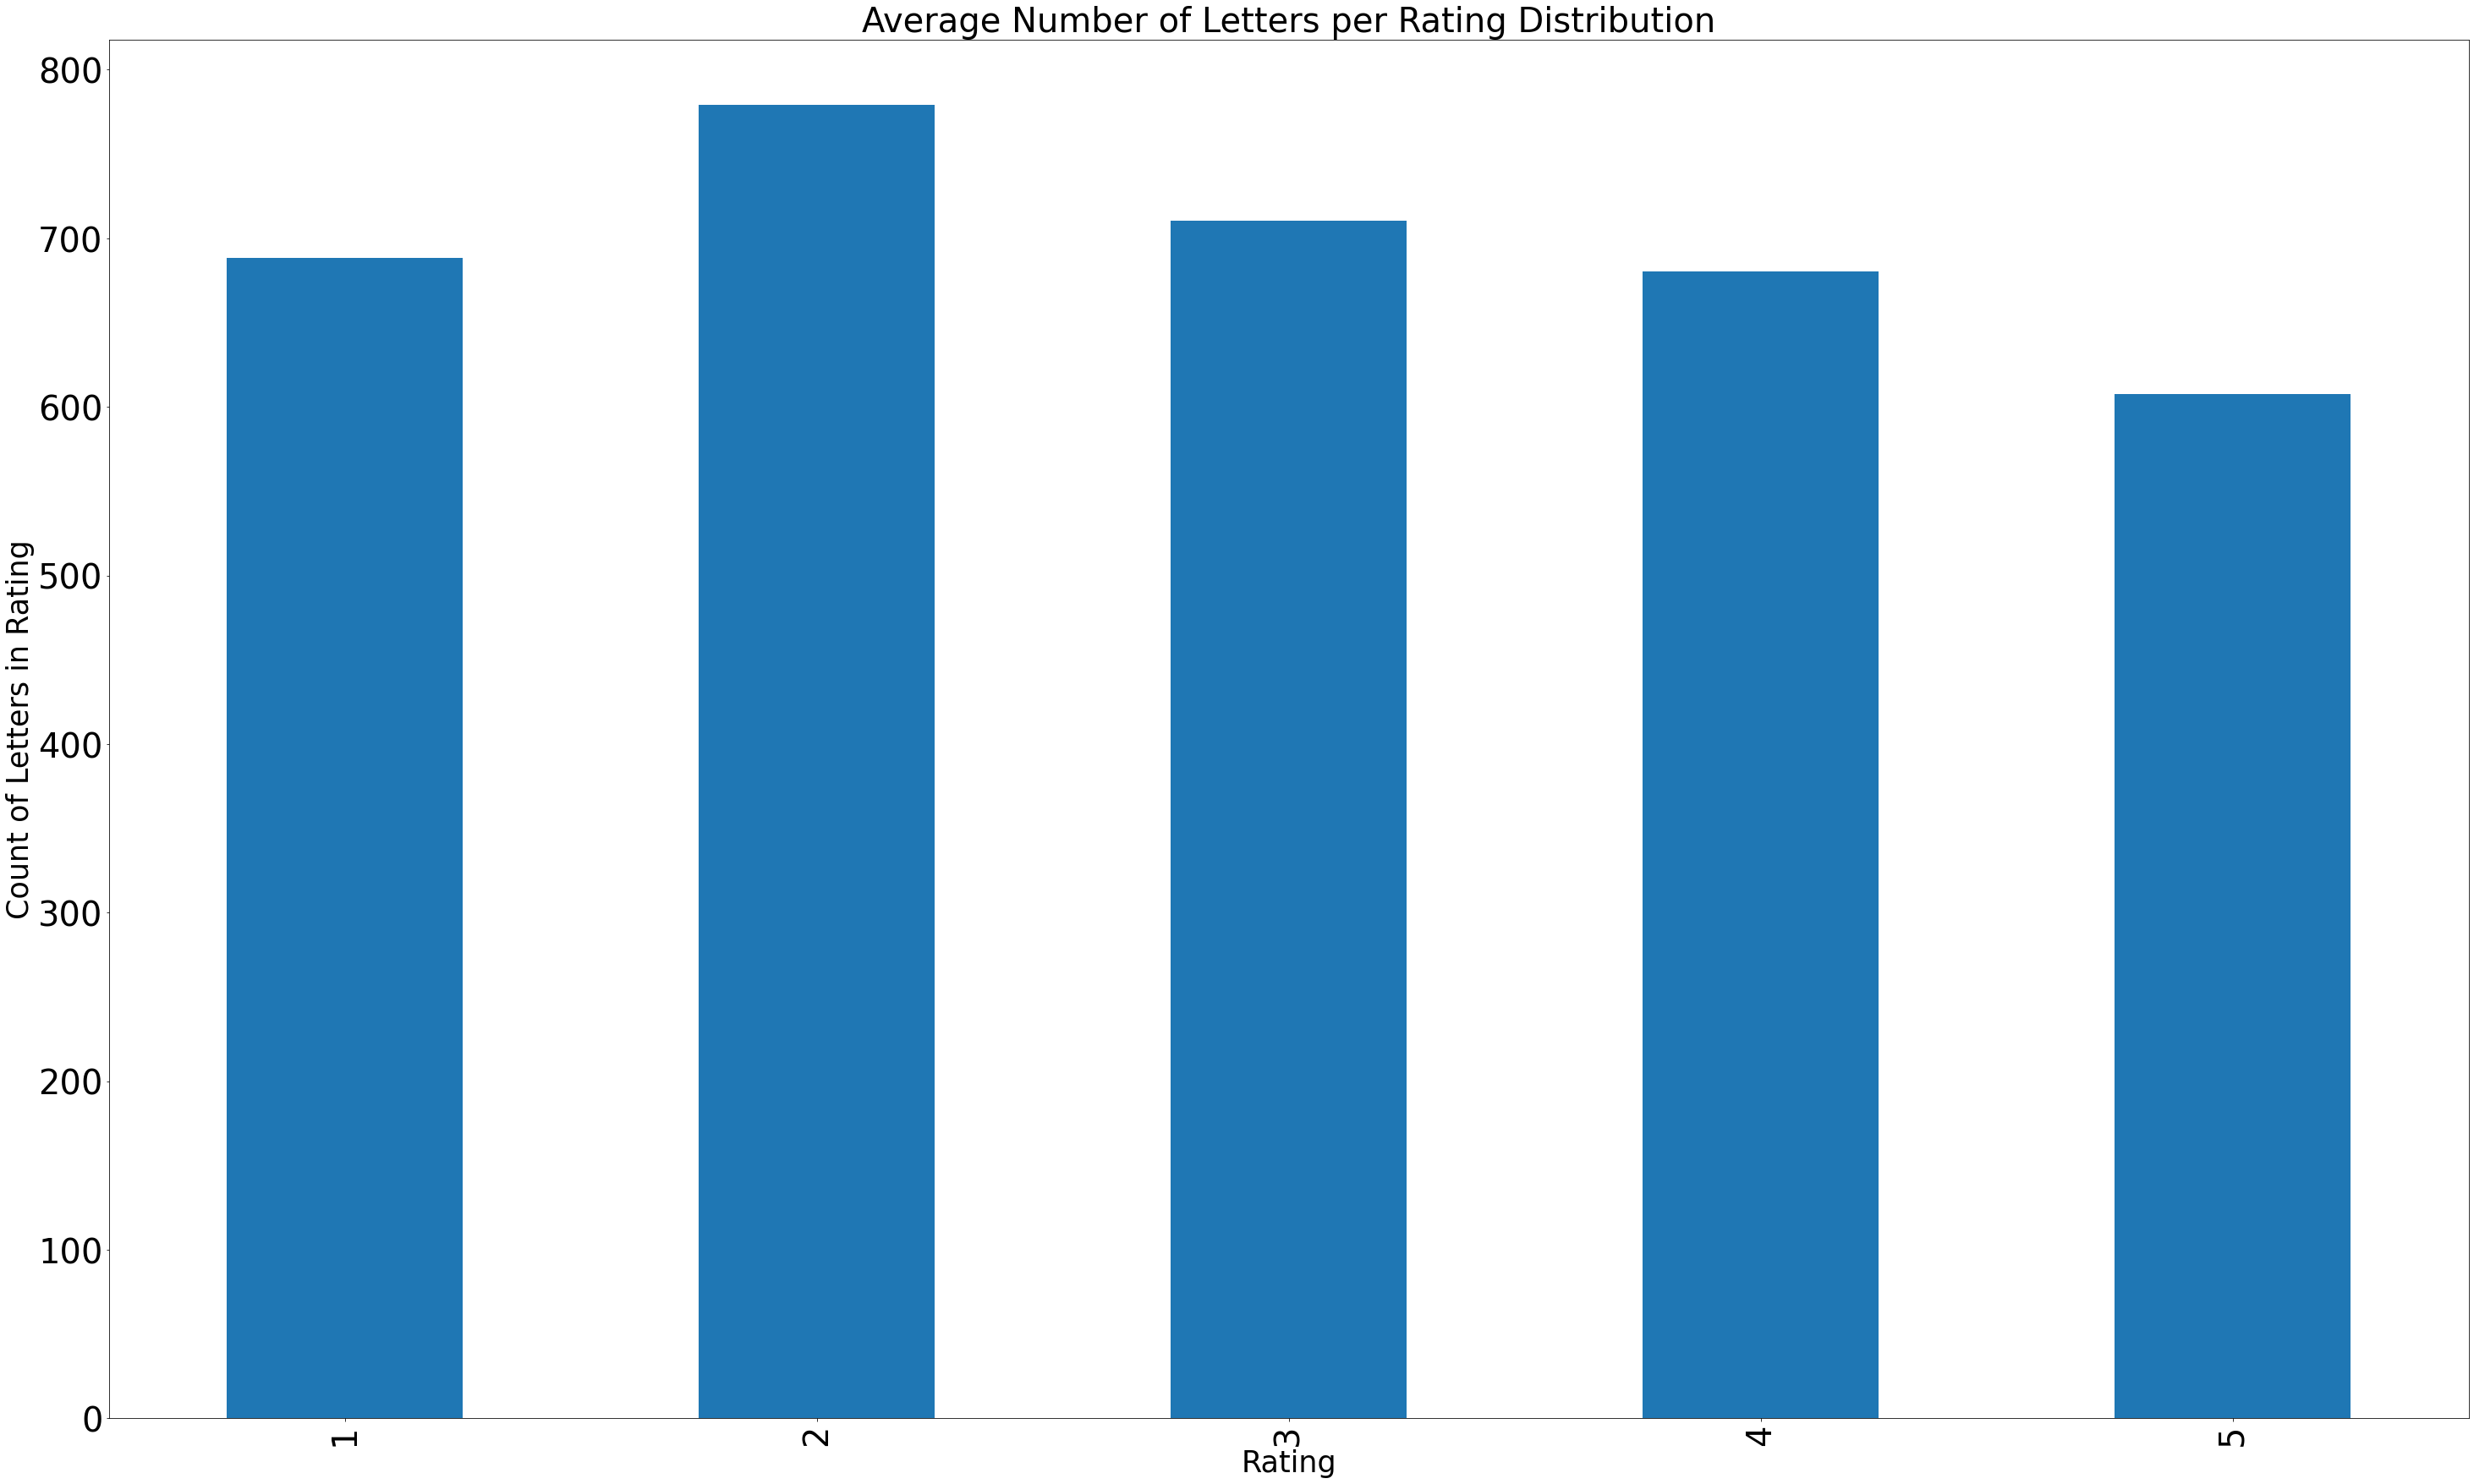

In [25]:
letter_avg = data.groupby('Rating')['review_len'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Letters in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Letters per Rating Distribution', fontsize=40)
plt.show()

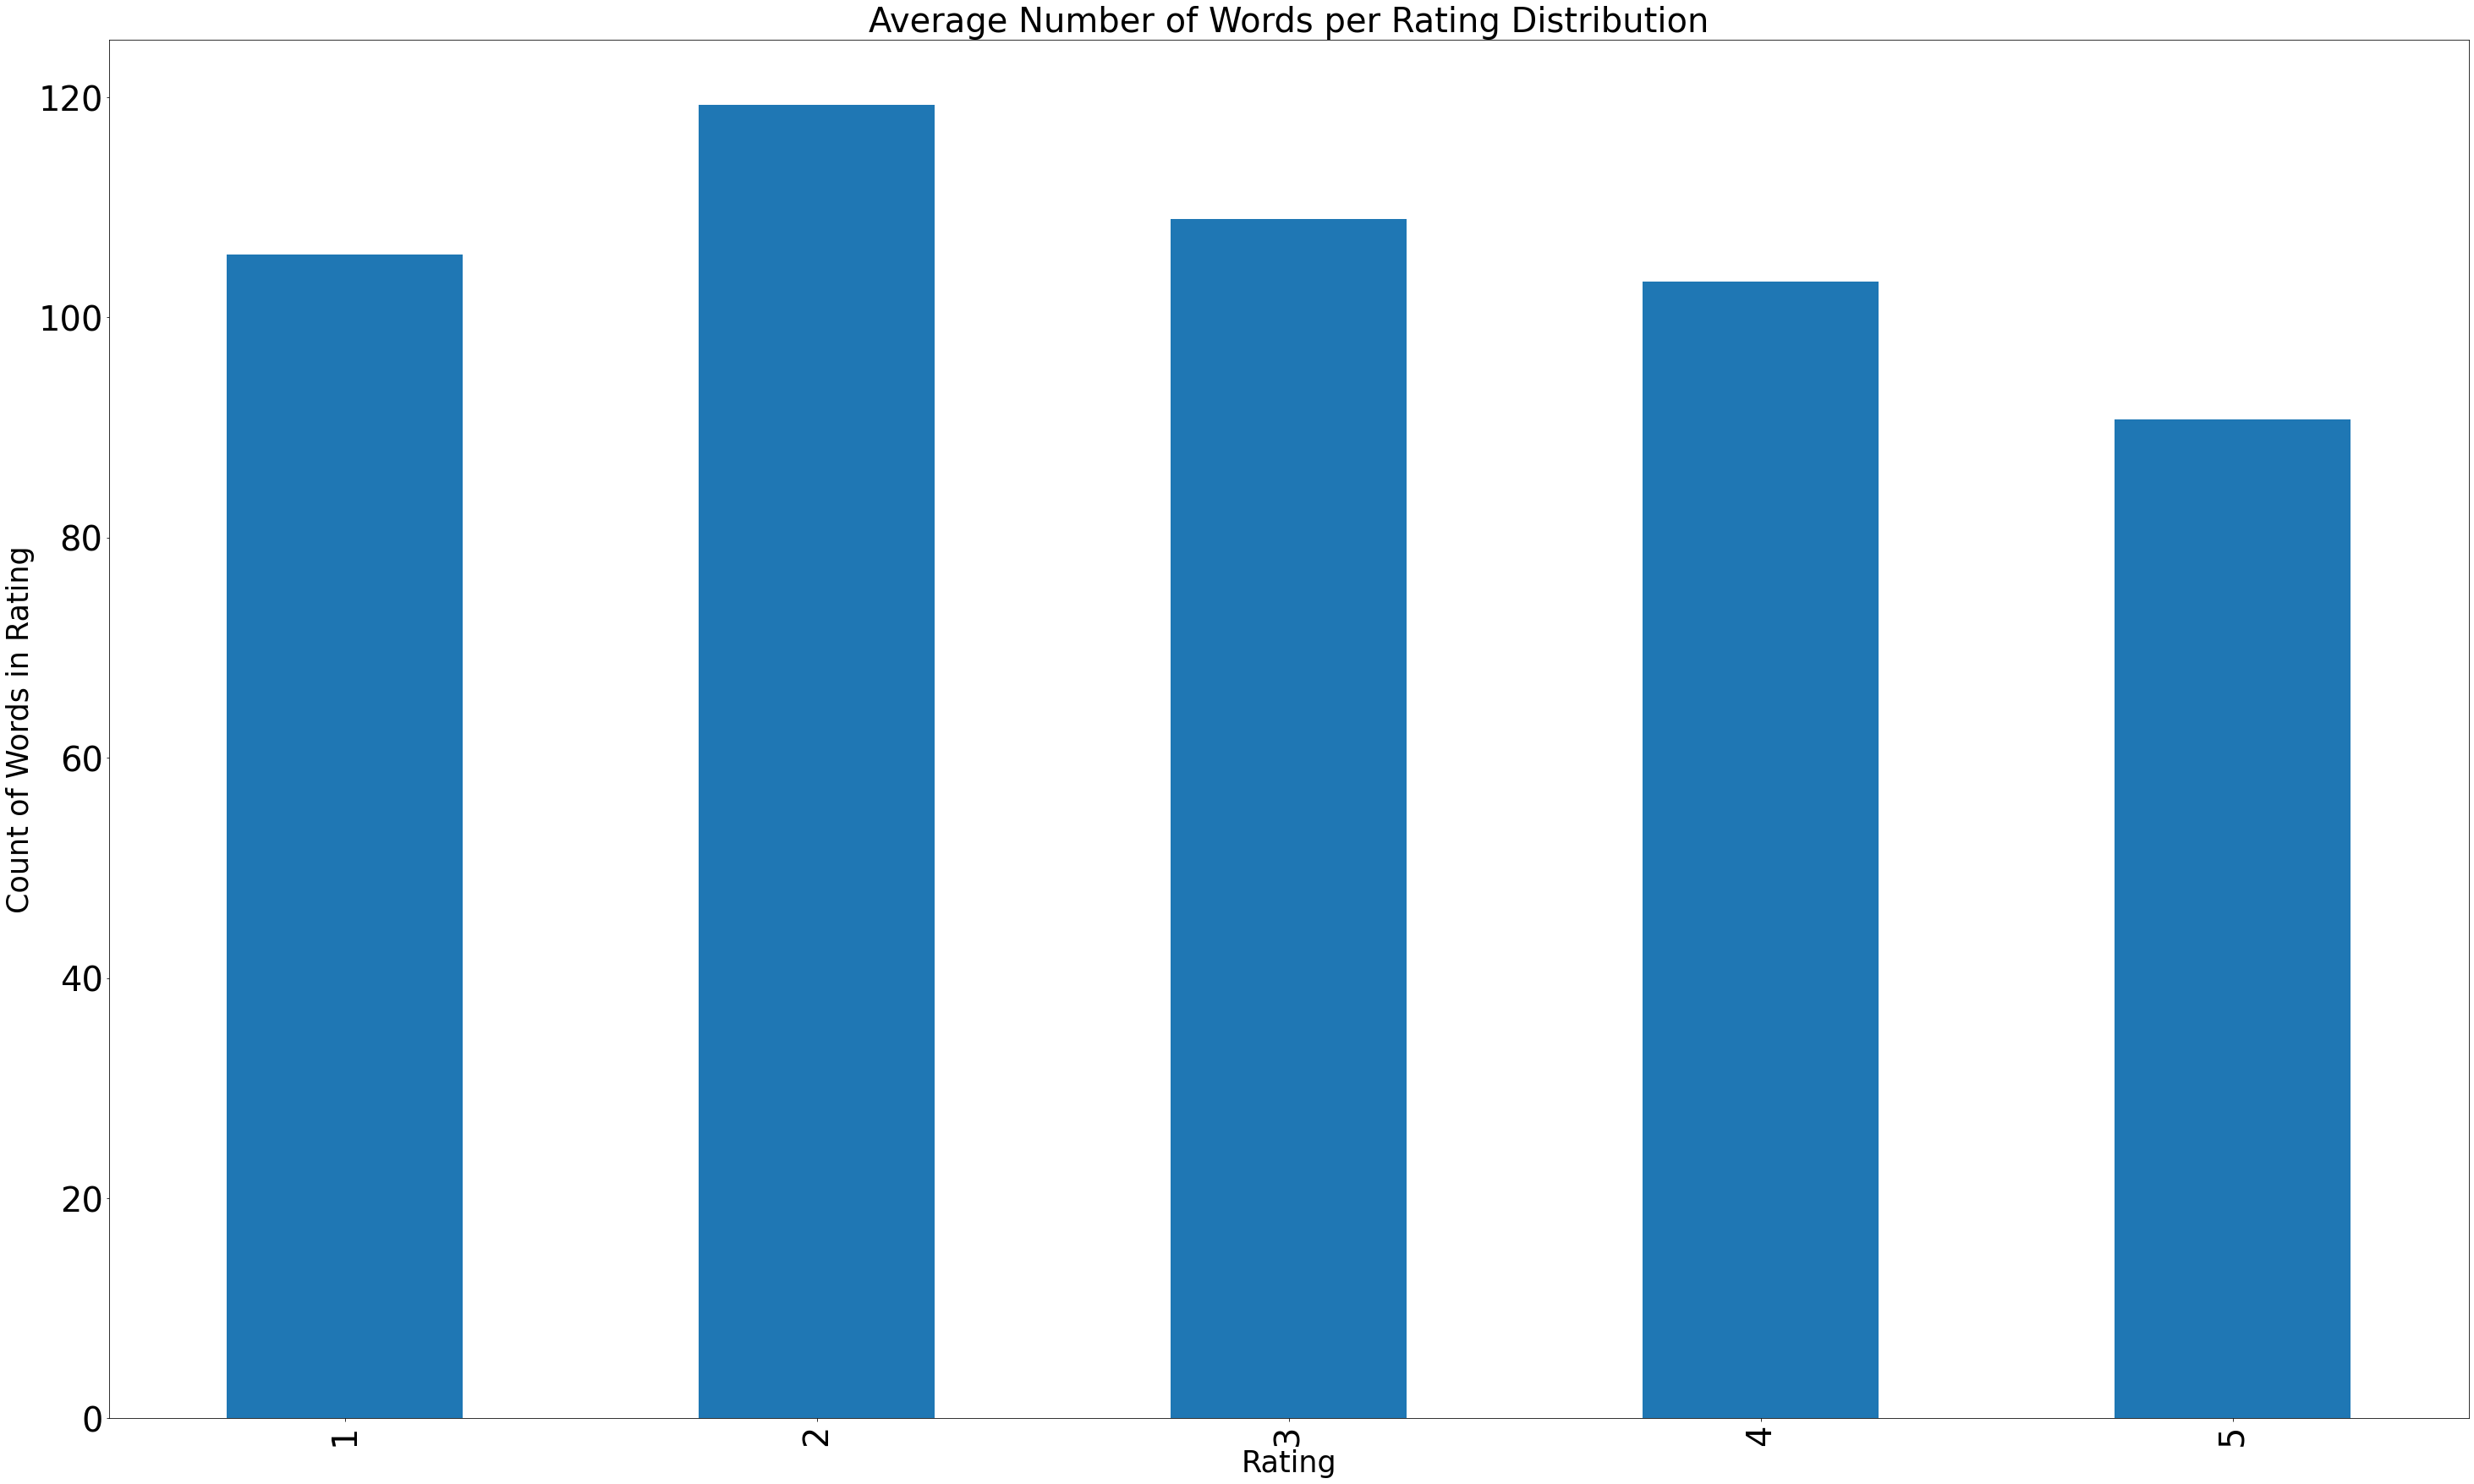

In [26]:
word_avg = data.groupby('Rating')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

C:\Users\Shriprada\AppData\Local\Temp\ipykernel_2708\2566227437.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlation, dtype=np.bool)


<AxesSubplot:>

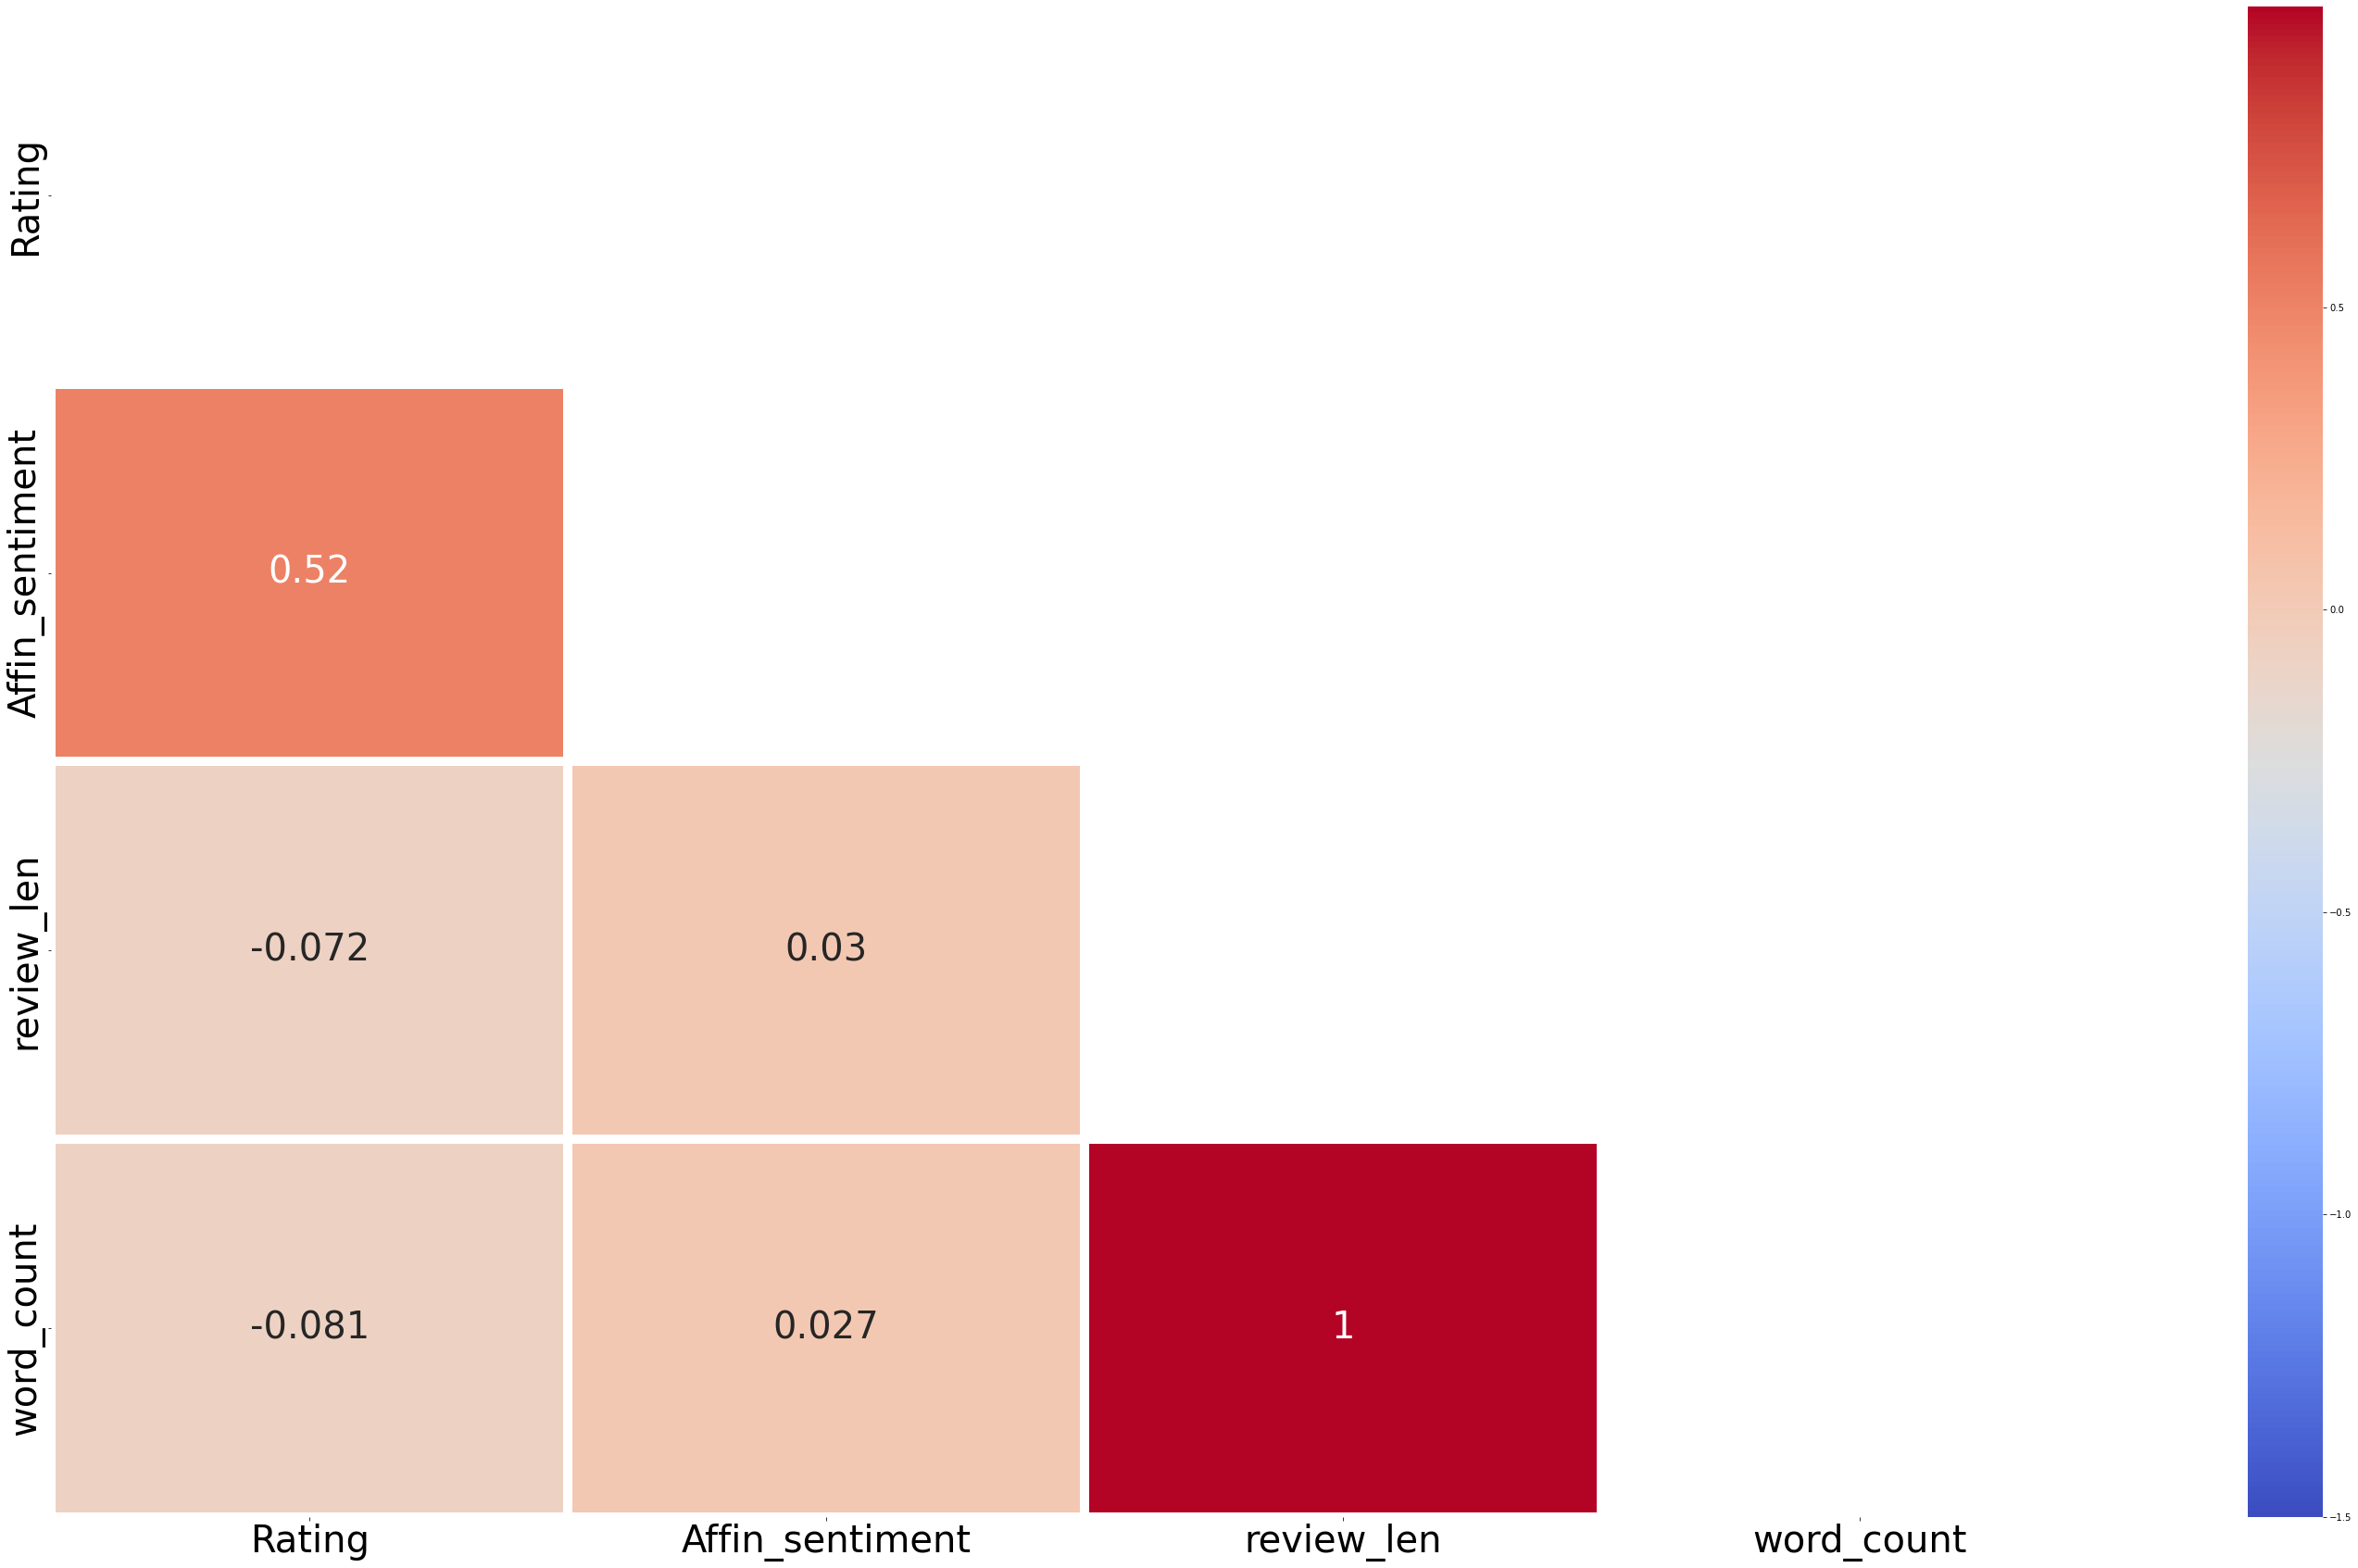

In [27]:
correlation = data[['Rating','Affin_sentiment', 'review_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask)

In [28]:
words = data['lemma_str']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



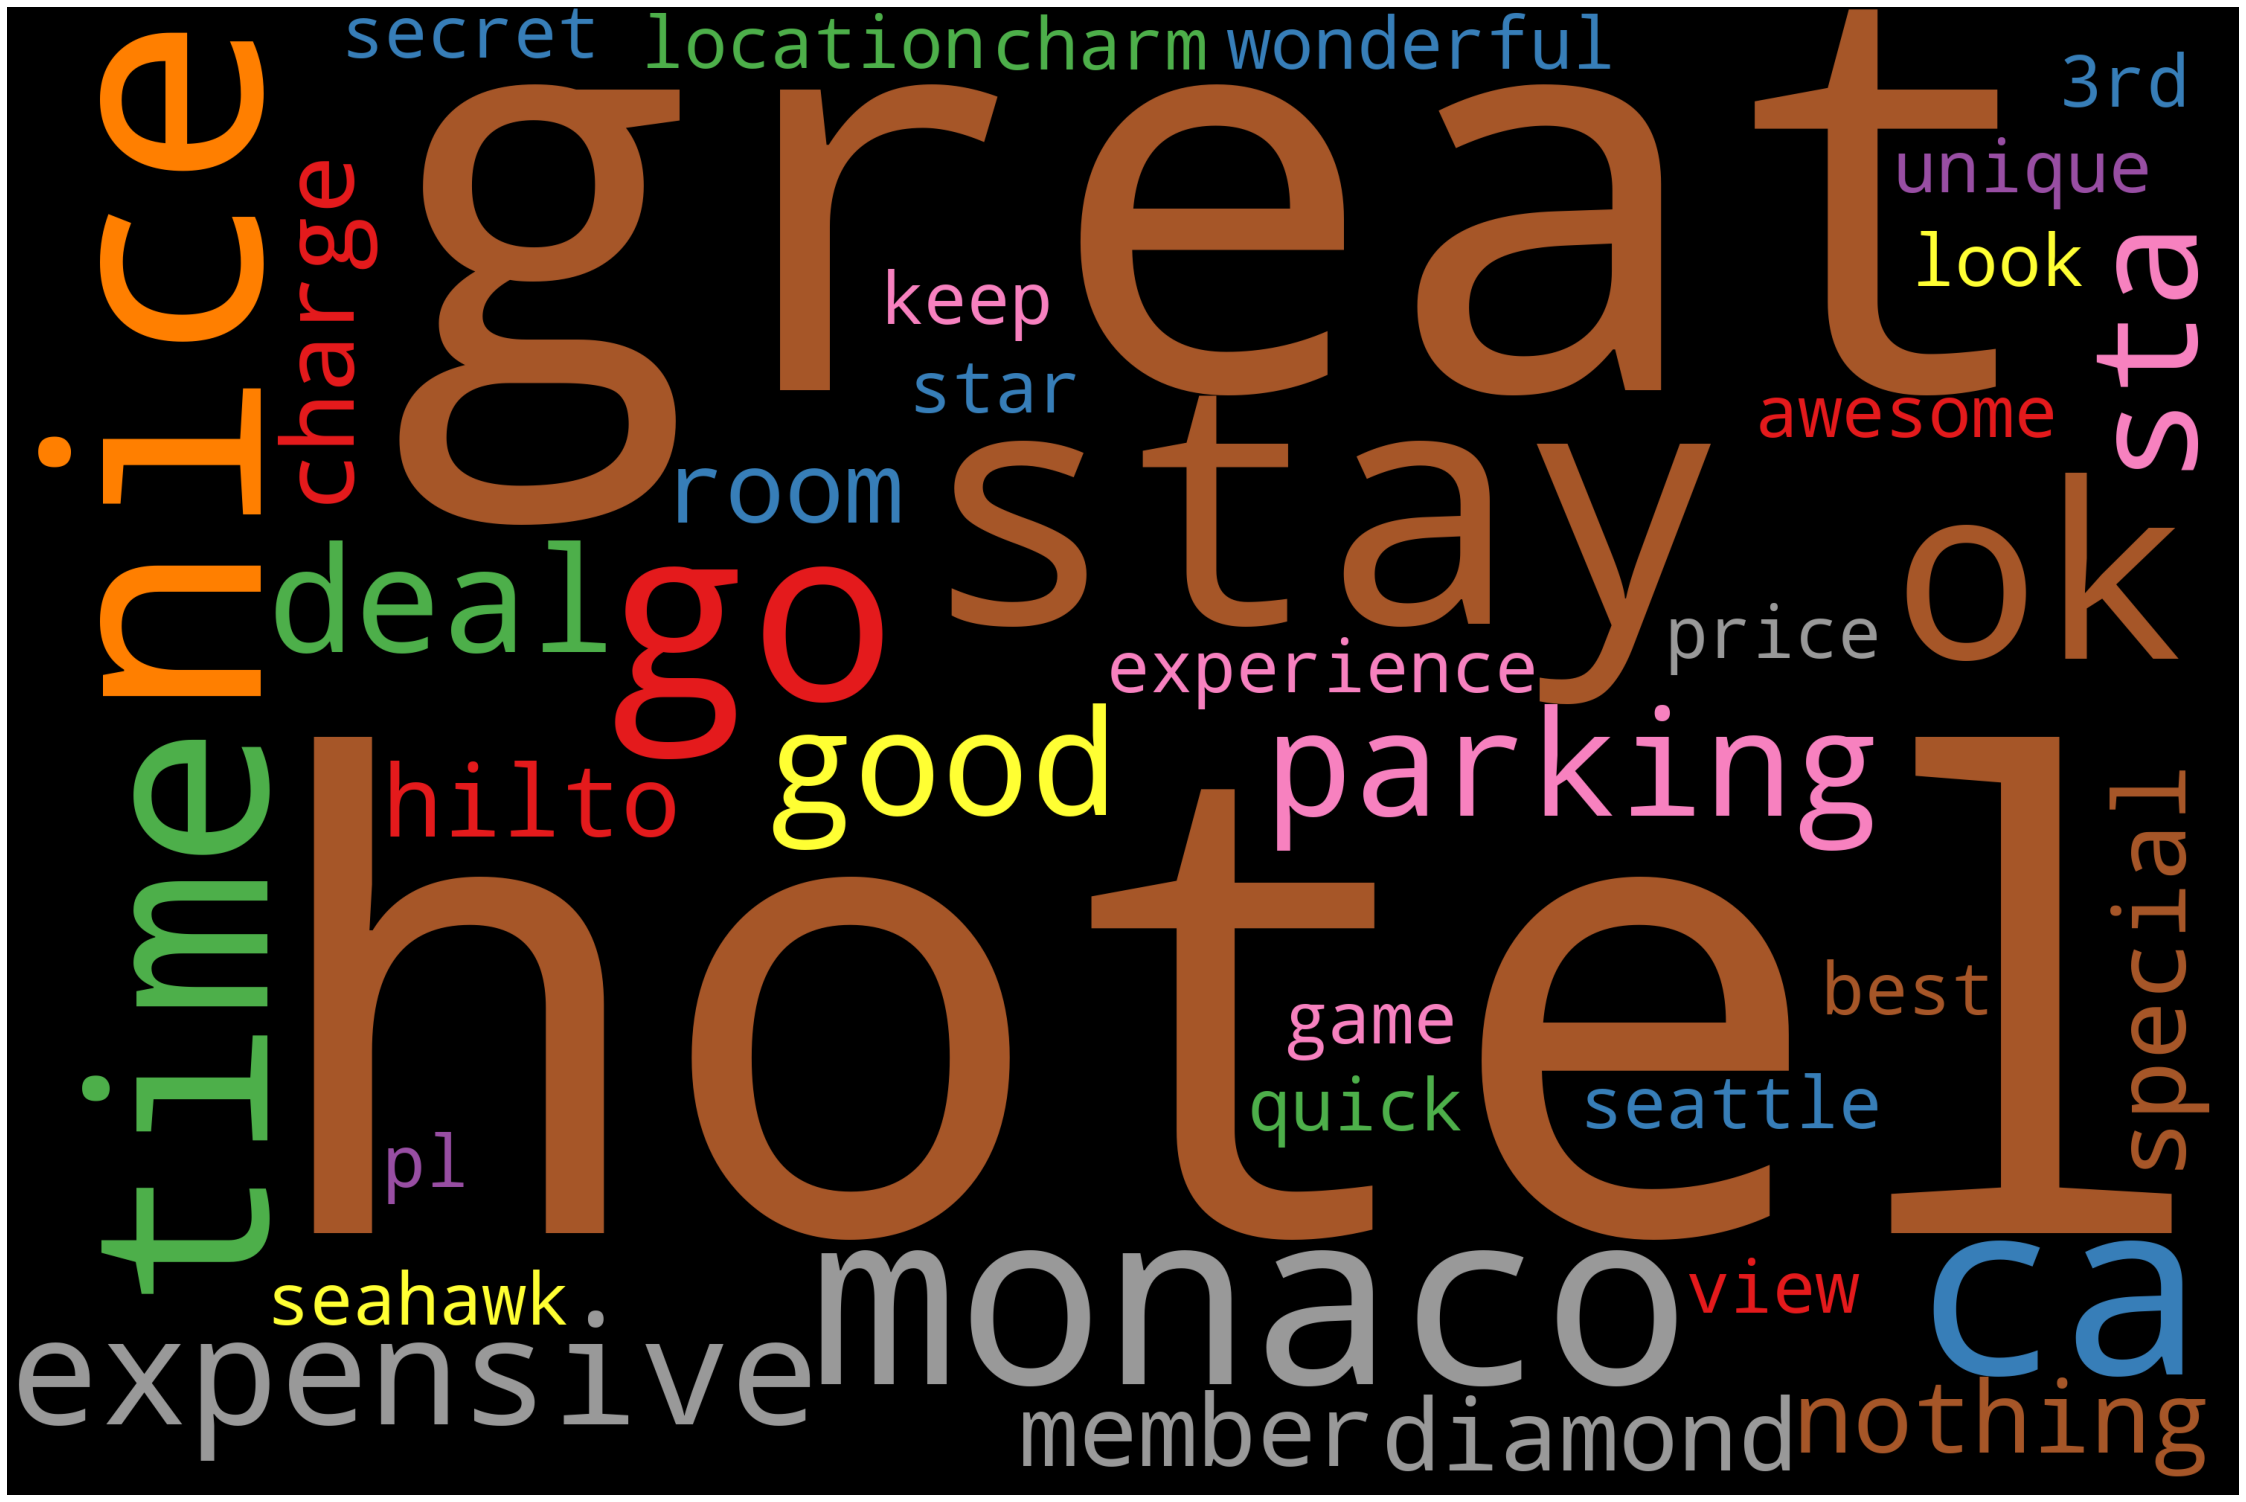

In [29]:
from wordcloud import WordCloud, STOPWORDS
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis('off')
    
STOPWORDS.add('pron')
STOPWORDS.add('rt')
STOPWORDS.add('yeah')
wordcloud = WordCloud(width = 3000, height= 2000, background_color='black', max_words = 40,
                     colormap='Set1', stopwords=STOPWORDS).generate(str(data['lemma_str']))
plot_cloud(wordcloud)

In [30]:
def textblob_sentiment(stat):
    blob = TextBlob(stat)
    
    if blob.sentiment.polarity > 0 :
        return "positive"
    elif blob.sentiment.polarity == 0 :
        return "neutral"
    else:
        return "negative"
  

#def getAnalysis(score):
  #if score < 0:
   #return ‘Negative’
#  elif score == 0:
   # return ‘Neutral’
 # else:
   # return ‘Positive’

In [31]:
data["polarity"] = data["lemma_str"].apply(textblob_sentiment)

C:\Users\Shriprada\AppData\Local\Temp\ipykernel_2708\3256739123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["polarity"] = data["lemma_str"].apply(textblob_sentiment)


In [32]:
data

Rating                                         lemmatized  \
0           4  [nice, hotel, expensive, parking, get, good, d...   
1           2  [ok, nothing, special, charge, diamond, member...   
2           3  [nice, room, 4, experience, hotel, monaco, sea...   
3           5  [unique, great, stay, wonderful, time, hotel, ...   
4           5  [great, stay, great, stay, go, seahawk, game, ...   
...       ...                                                ...   
20486       5  [best, keep, secret, 3rd, time, stay, charm, 5...   
20487       4  [great, location, price, view, hotel, great, q...   
20488       2  [ok, look, nice, modern, outside, desk, staff,...   
20489       1  [hotel, theft, ruin, vacation, hotel, open, se...   
20490       2  [people, talk, ca, believe, excellent, rating,...   

                                               lemma_str  Affin_score  \
0      nice hotel expensive parking get good deal sta...         26.0   
1      ok nothing special charge diamond member hilto...         36.0   
2      nice room 4 experience hotel monaco seattle go...         20.0   
3      unique great stay wonderful time hotel monaco ...         39.0   
4      great stay great stay go seahawk game awesome ...         37.0   
...                                                  ...          ...   
20486  best keep secret 3rd time stay charm 5-star ca...         23.0   
20487  great location price view hotel great quick pl...         21.0   
20488  ok look nice modern outside desk staff particu...          8.0   
20489  hotel theft ruin vacation hotel open sept 17 2...         -9.0   
20490  people talk ca believe excellent rating hotel ...         15.0   

       Affin_sentiment  word_count  review_len  polarity  
0                    1          81         523  positive  
1                    1         237        1551  positive  
2                    1         205        1313  positive  
3                    1          84         541  positive  
4                    1         174        1093  positive  
...                ...         ...         ...       ...  
20486                1         105         663  positive  
20487                1          39         297  positive  
20488                1          60         402  positive  
20489                0         740        5048  positive  
20490                1          83         548  positive  

[20491 rows x 8 columns]

In [33]:
data["polarity"].value_counts()

positive    19381
negative     1086
neutral        24
Name: polarity, dtype: int64

In [34]:
group = data.groupby(["polarity","Affin_sentiment"])
group.mean()

Rating  Affin_score  word_count  review_len
polarity Affin_sentiment                                               
negative 0                1.438453    -7.427902   83.821805  548.208675
         1                2.188841     4.798283   86.193133  566.725322
neutral  0                2.882353    -2.470588   31.588235  205.705882
         1                3.142857     2.714286   21.142857  145.571429
positive 0                1.943428    -3.871880  101.623960  666.514143
         1                4.153834    24.094089  100.836368  667.348403

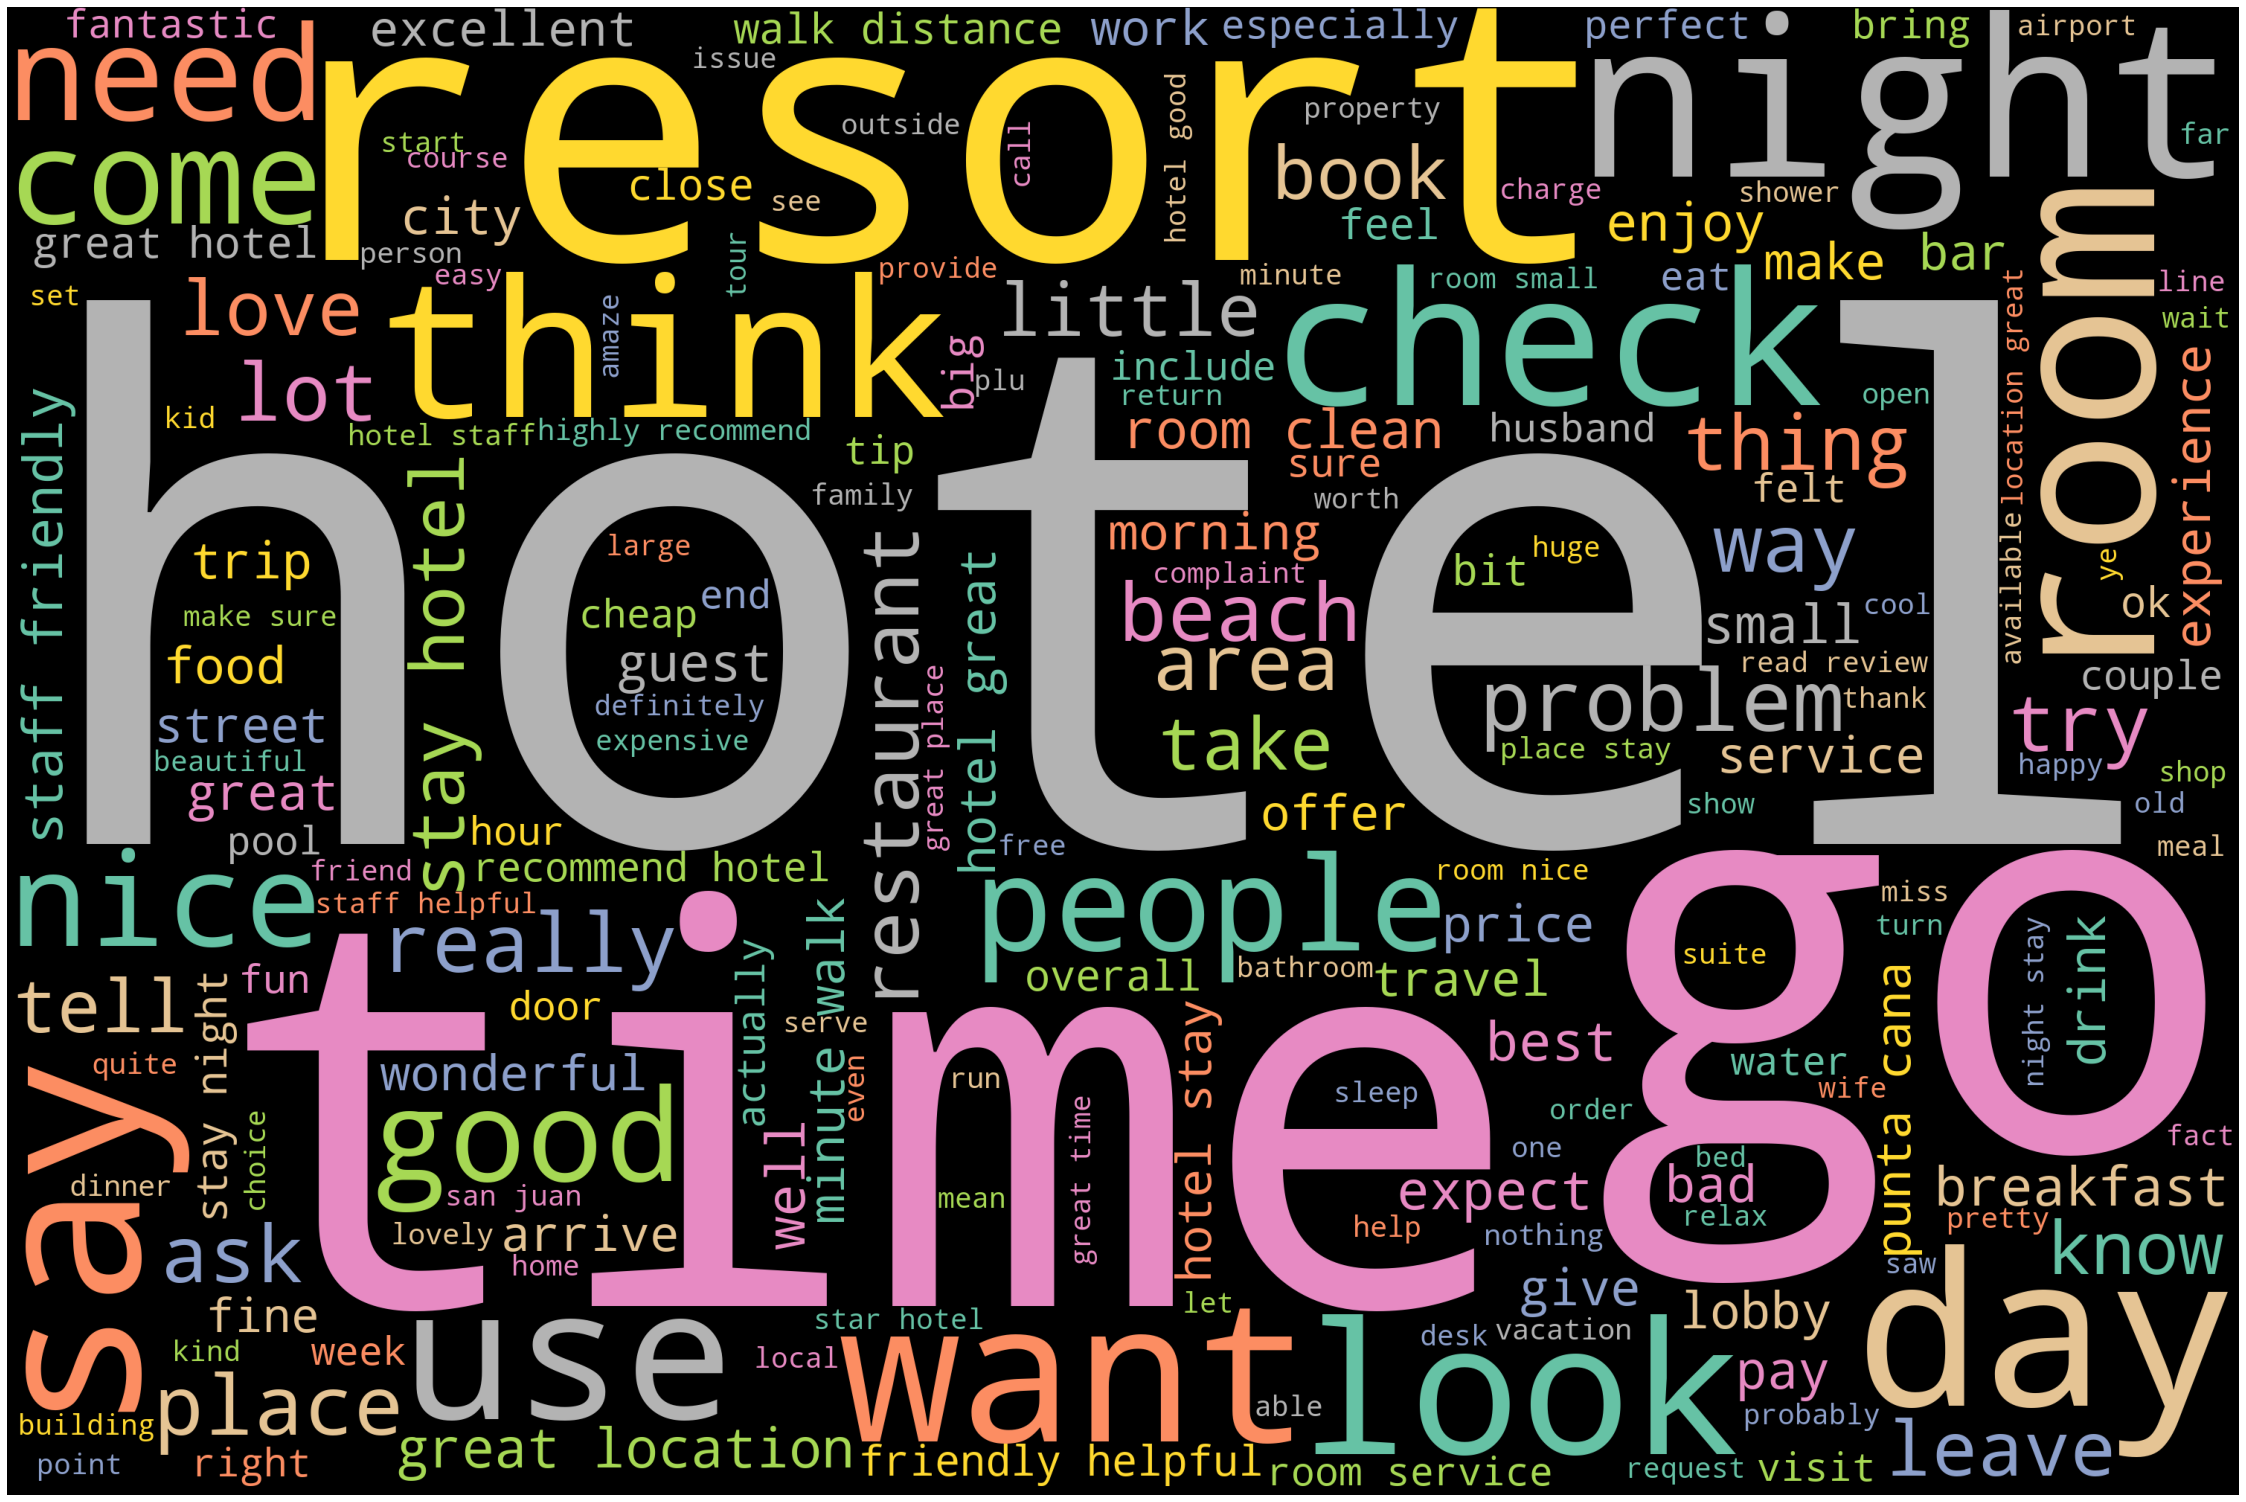

In [35]:
positive_wordcloud = WordCloud(width = 3000, height = 2000, background_color = "black",max_words = 200, colormap = "Set2",
                     stopwords = STOPWORDS).generate(data[data["polarity"] == 'positive']["lemma_str"].str.cat(sep = " "))
#plot
plot_cloud(positive_wordcloud) 

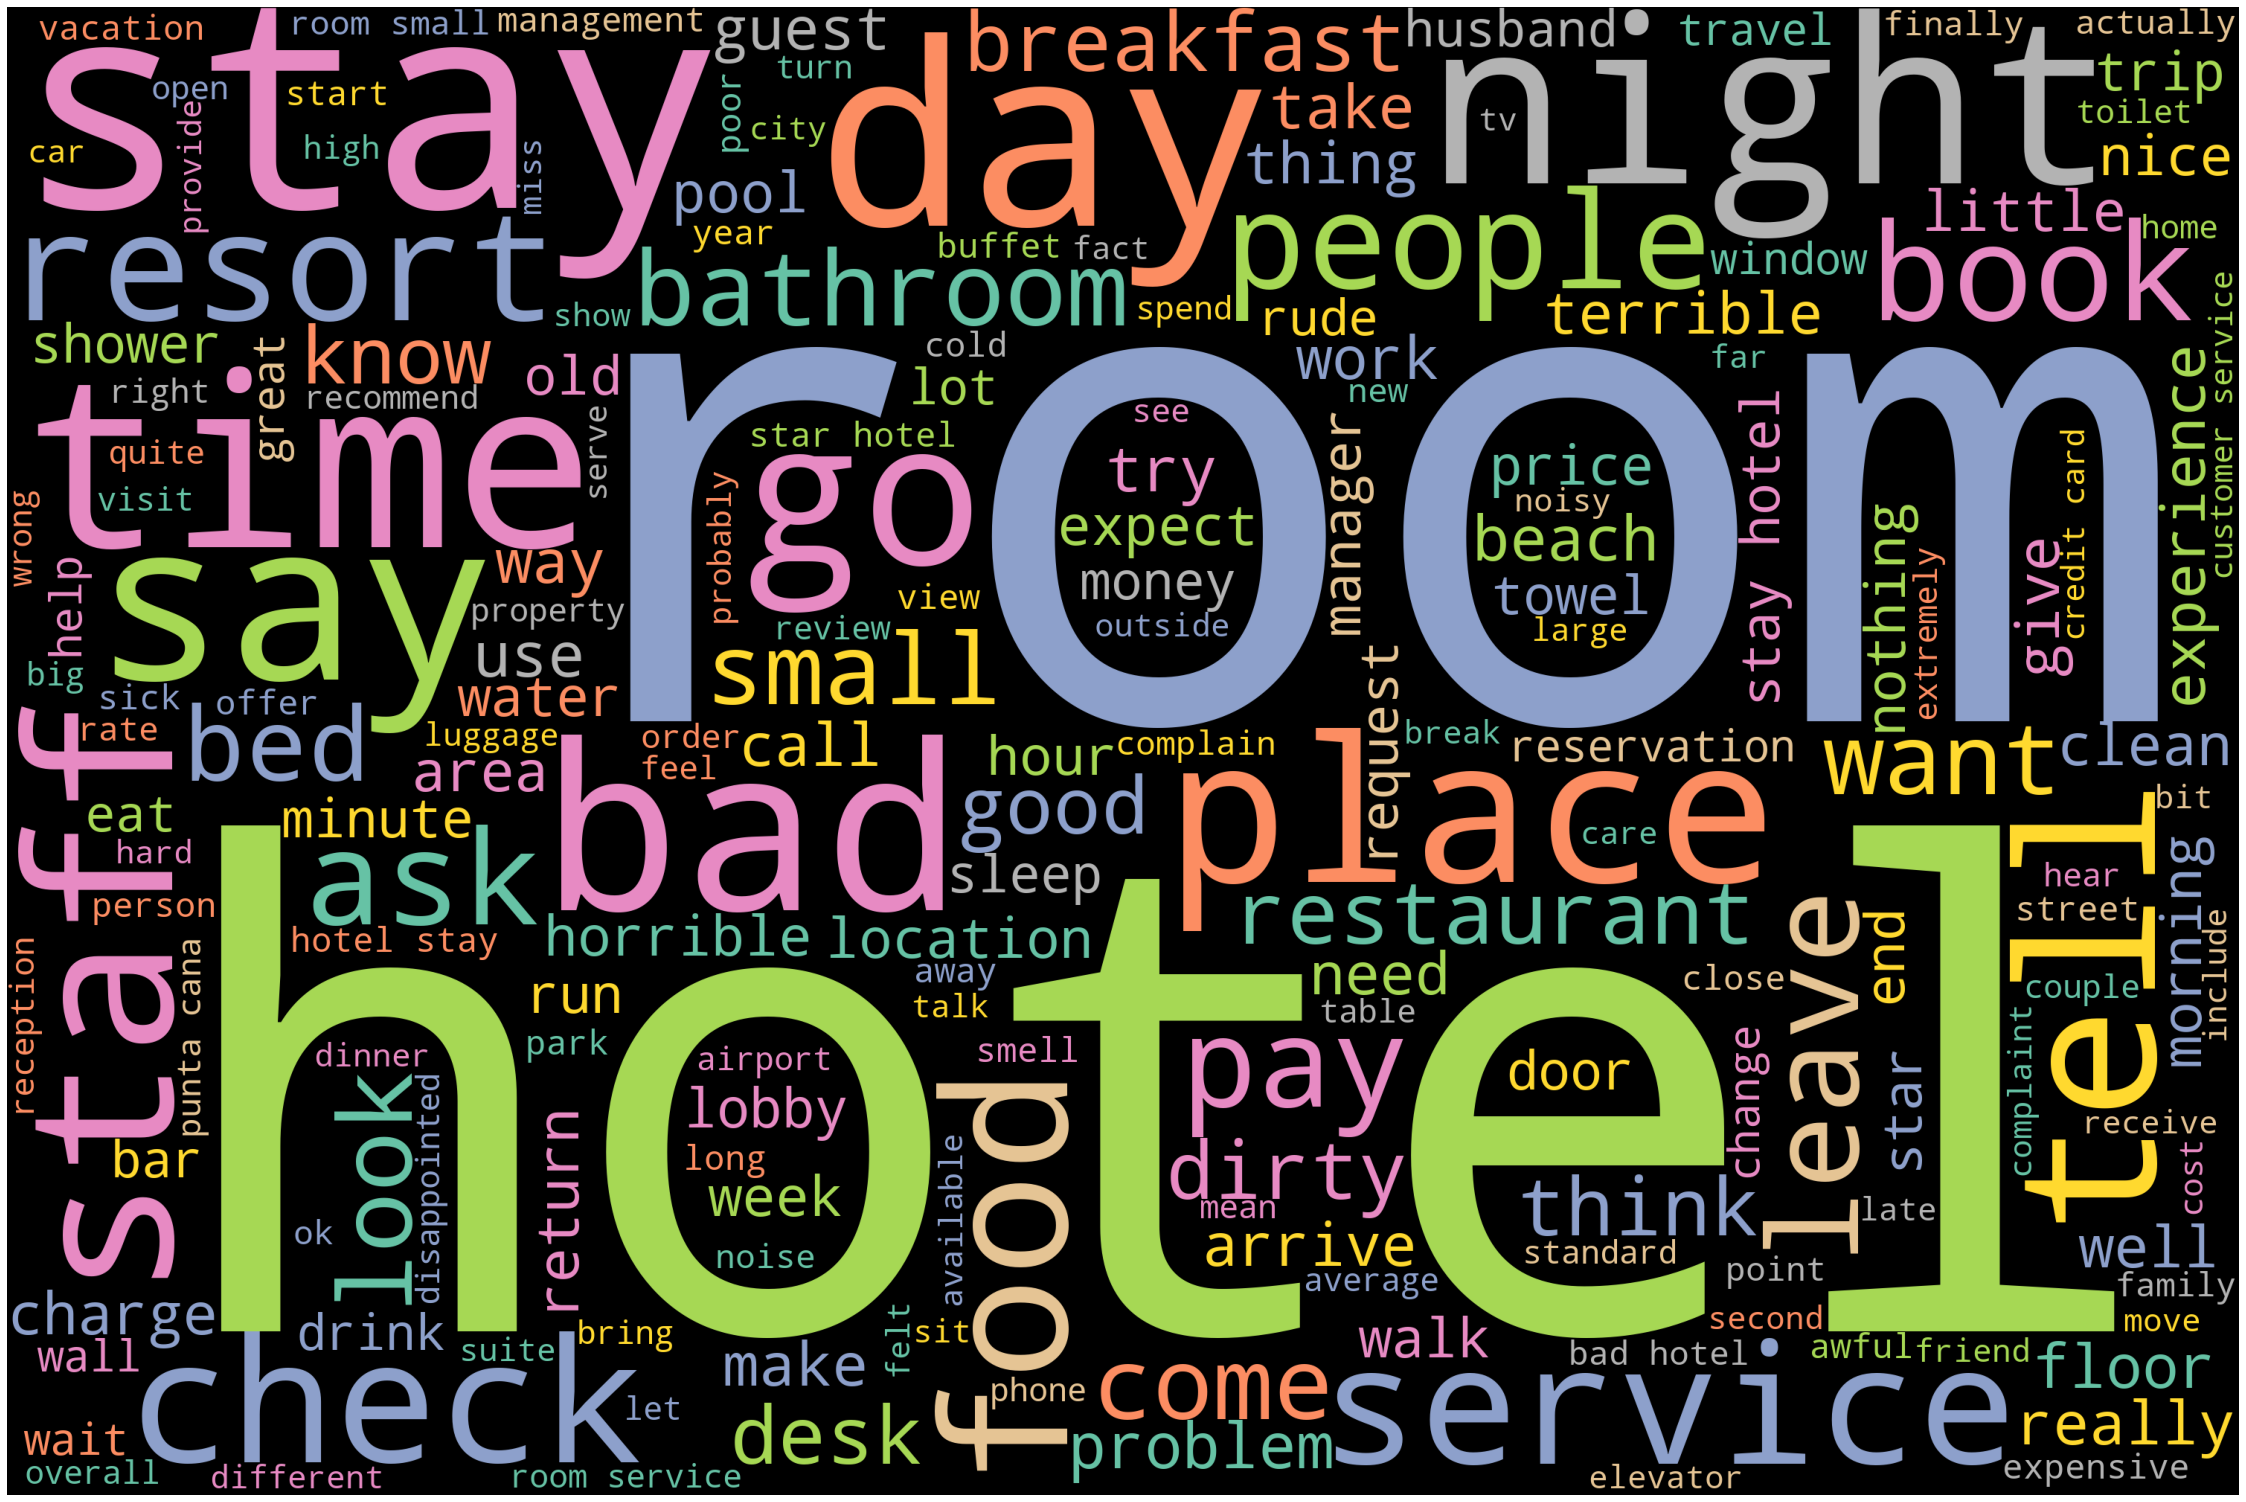

In [36]:
negative_wordcloud = WordCloud(width = 3000, height = 2000, background_color = "black",max_words = 200, colormap = "Set2",
                     stopwords = STOPWORDS).generate(data[data["polarity"] == 'negative']["lemma_str"].str.cat(sep = " "))
#plot
plot_cloud(negative_wordcloud) 

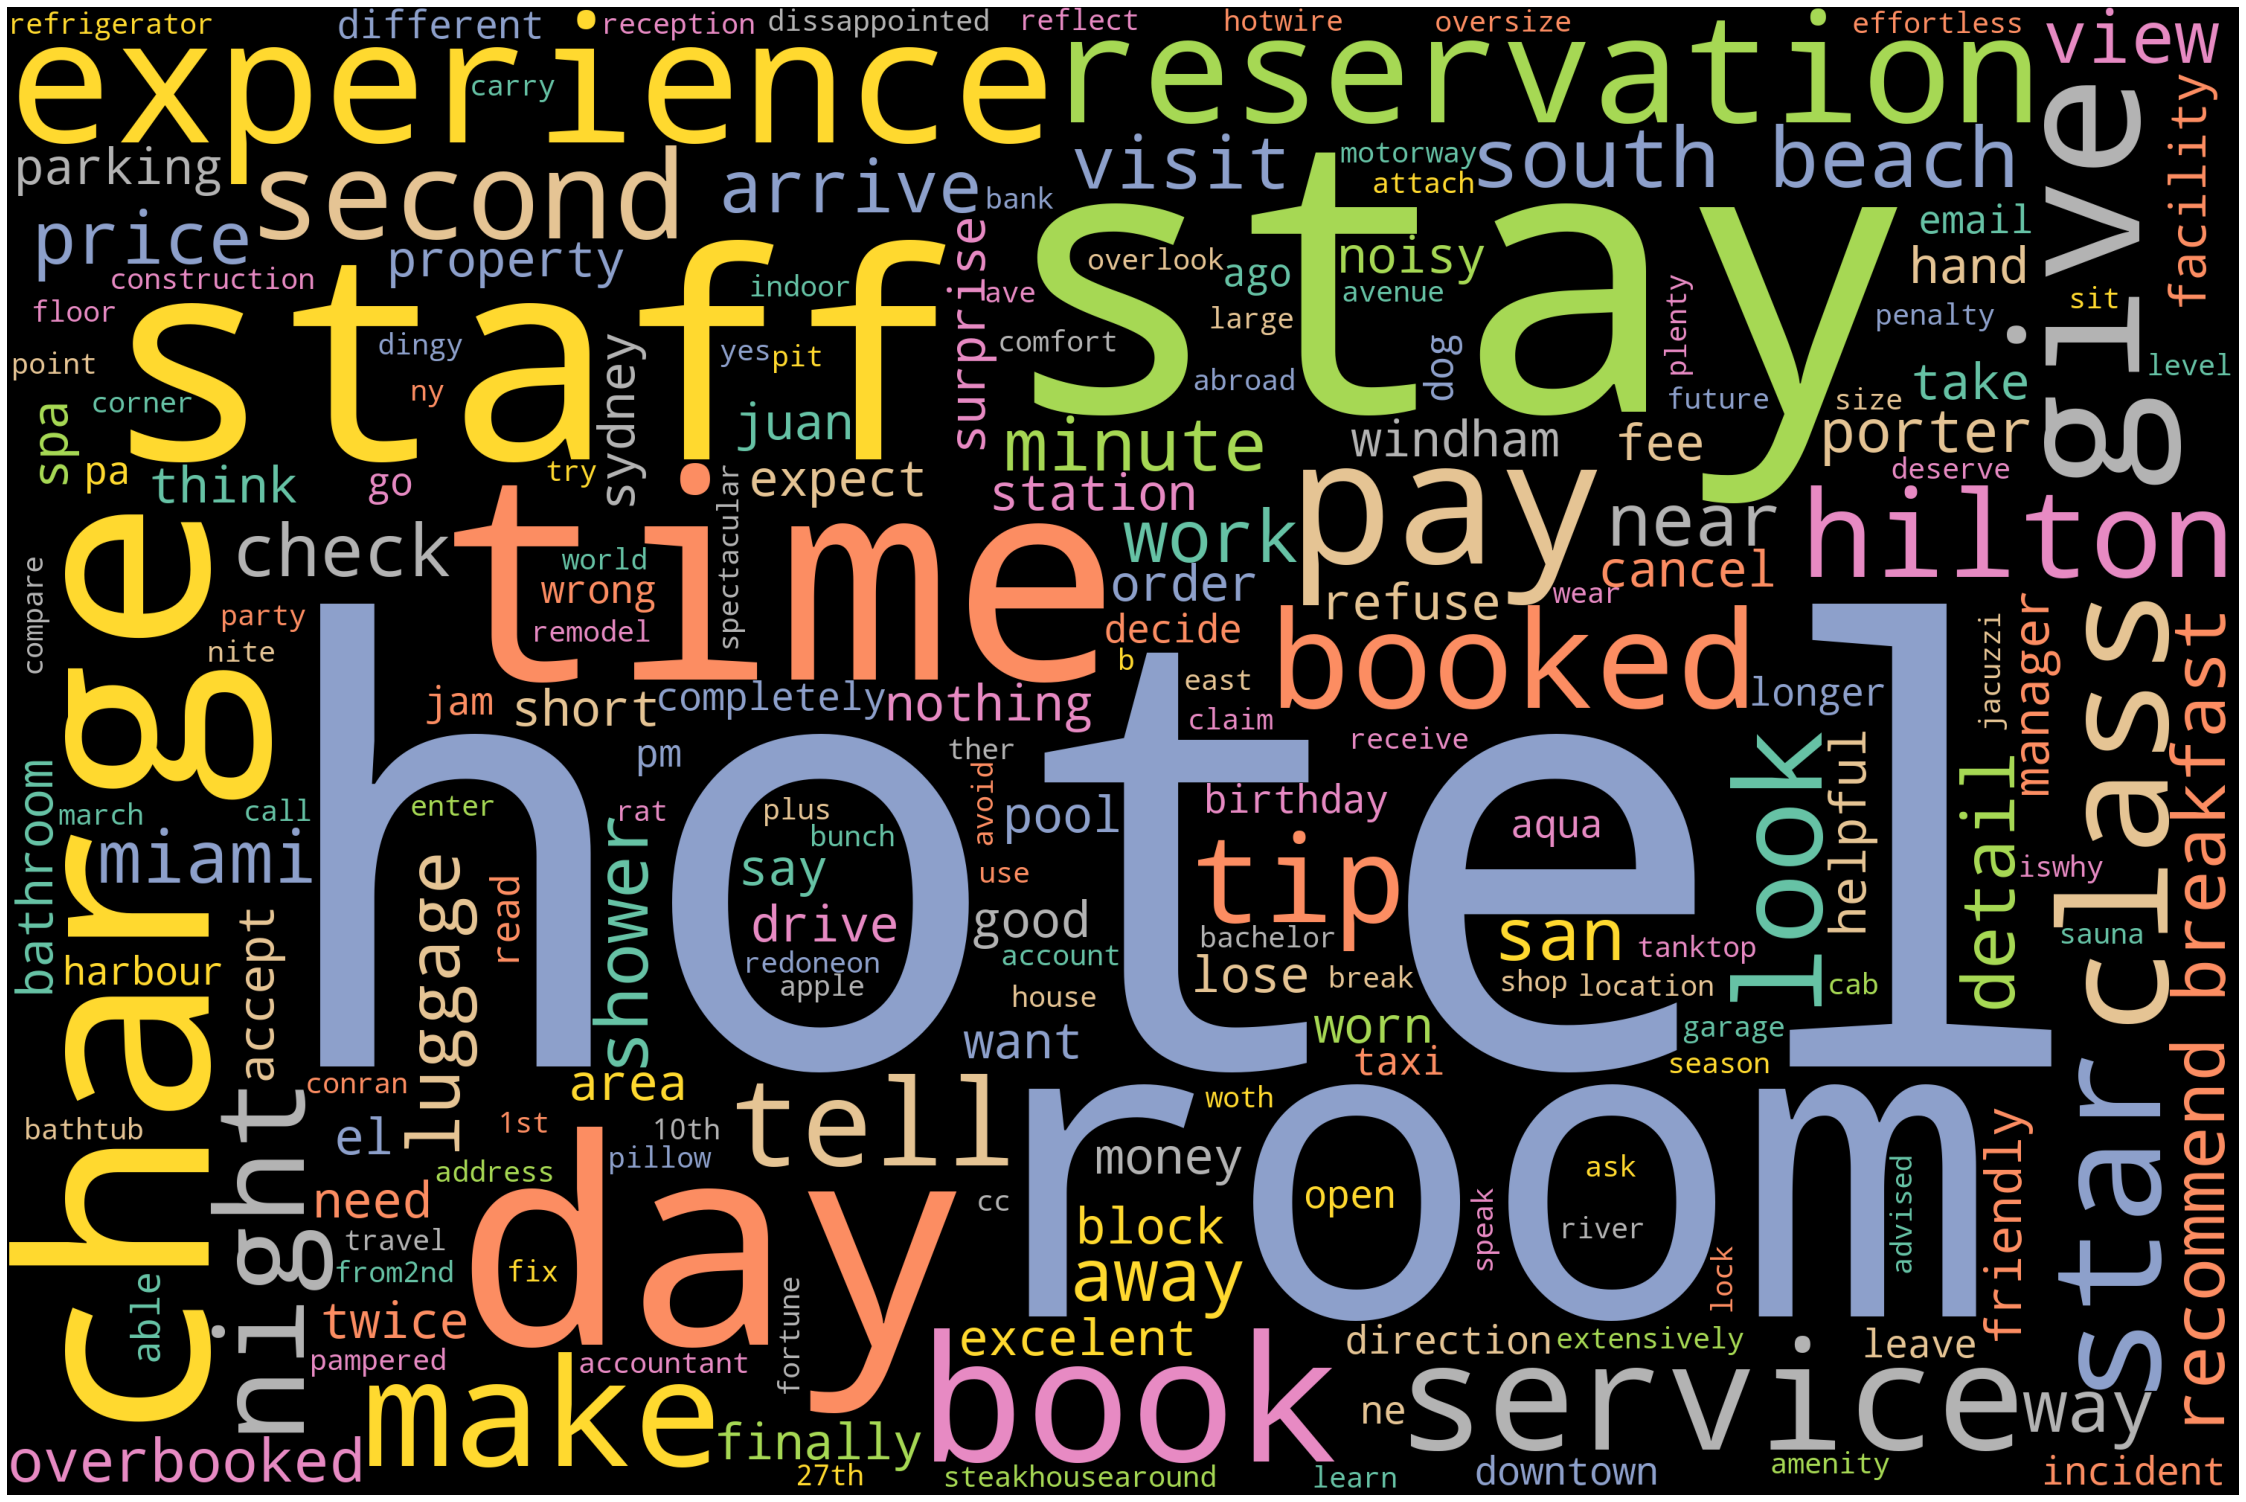

In [37]:
neutral_wordcloud = WordCloud(width = 3000, height = 2000, background_color = "black",max_words = 200, colormap = "Set2",
                     stopwords = STOPWORDS).generate(data[data["polarity"] == 'neutral']["lemma_str"].str.cat(sep = " "))
#plot
plot_cloud(neutral_wordcloud) 

In [38]:
stop_words_keywords = stopwords.words('english')

# special additioanl stop words added for keyword extraction
stop_words_keywords.extend([
    "will", "always", "go", "one", "very", "good", "only", "mr", "lot", "two",
    "th", "etc", "don", "due", "didn", "since", "nt", "ms", "ok", "almost",
    "put", "pm", "hyatt", "grand", "till", "add", "let", "hotel", "able",
    "per", "st", "couldn", "yet", "par", "hi", "well", "would", "I", "the",
    "s", "also", "great", "get", "like", "take", "thank"
])

In [39]:
stops = set(stopwords.words('english') + ['com'])
co = CountVectorizer(stop_words=stop_words_keywords)
counts = co.fit_transform(data['lemma_str'])
most_freq_terms = pd.DataFrame(counts.sum(axis=0),
                               columns=co.get_feature_names()).T.sort_values(
                                   0, ascending=False).head(25)

C:\Users\Shriprada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Unigram Frequency'}>

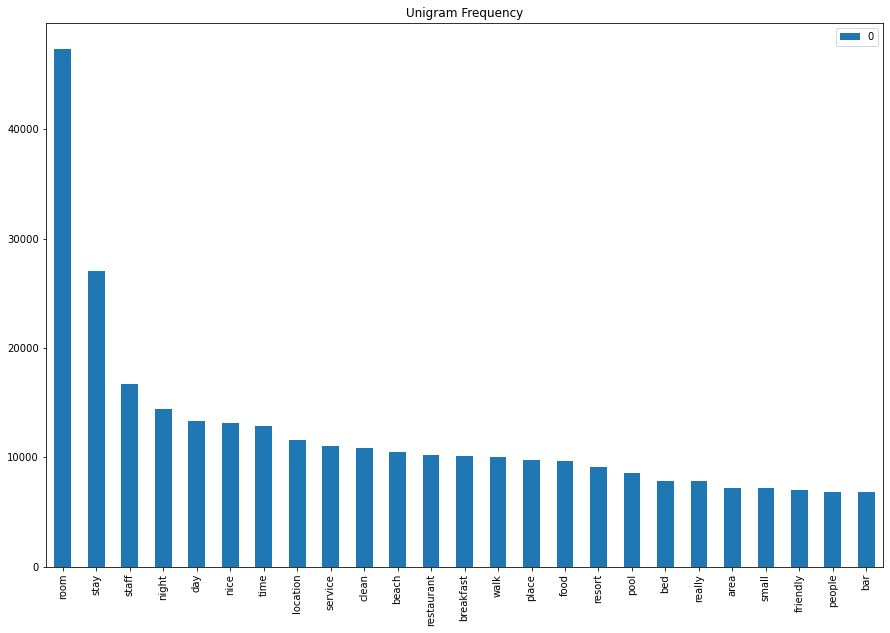

In [40]:
most_freq_terms.plot(kind='bar', title='Unigram Frequency', figsize=(15, 10))

In [41]:
co = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words_keywords)
counts1 = co.fit_transform(data['lemma_str'])
bi_grams = pd.DataFrame(counts1.sum(axis=0),
                        columns=co.get_feature_names()).T.sort_values(
                            0, ascending=False).head(25)

C:\Users\Shriprada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'bi-grams'}>

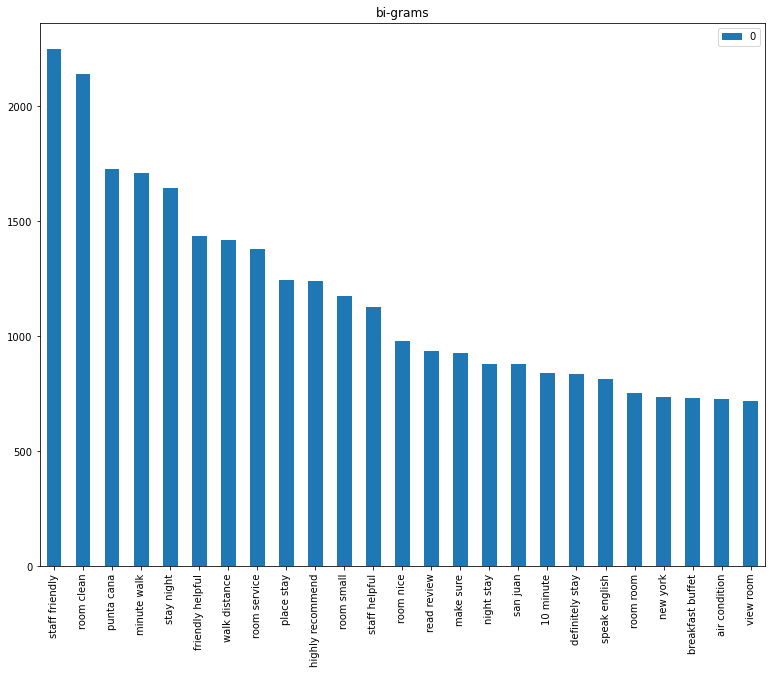

In [42]:
bi_grams.plot(kind='bar', title='bi-grams', figsize=(13, 10))


In [43]:
co = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words_keywords)
counts1 = co.fit_transform(data['lemma_str'])
tri_grams = pd.DataFrame(counts1.sum(axis=0),
                         columns=co.get_feature_names()).T.sort_values(
                             0, ascending=False).head(25)

C:\Users\Shriprada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'tri-grams'}>

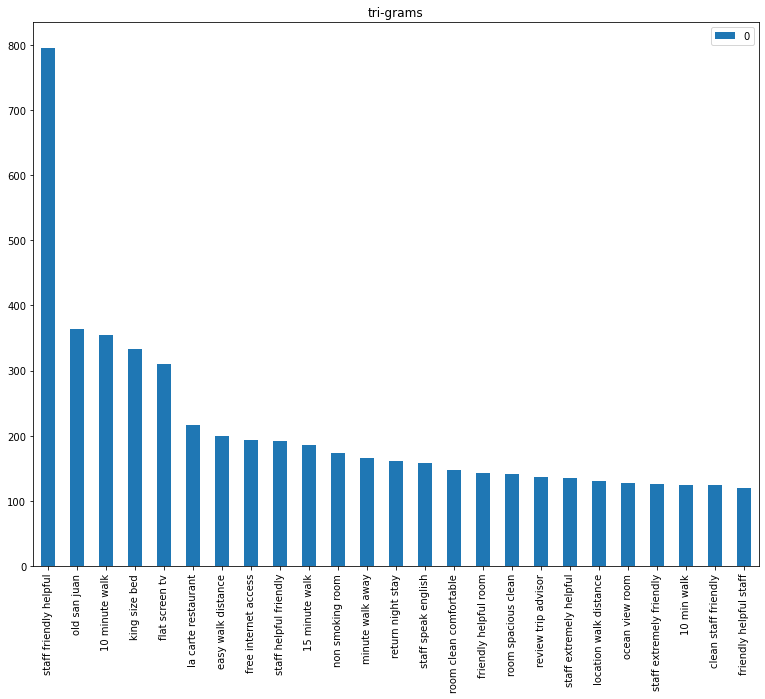

In [44]:
tri_grams.plot(kind='bar', title='tri-grams', figsize=(13, 10))

In [45]:
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(1,1))
tfidf2_x = tfidf2.fit_transform(data['lemma_str'])
most_freq_terms = pd.DataFrame(tfidf2_x.sum(axis=0),
                               columns=tfidf2.get_feature_names()).T.sort_values(
                                   0, ascending=False).head(25)

C:\Users\Shriprada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'most frequent terms & their frequency'}>

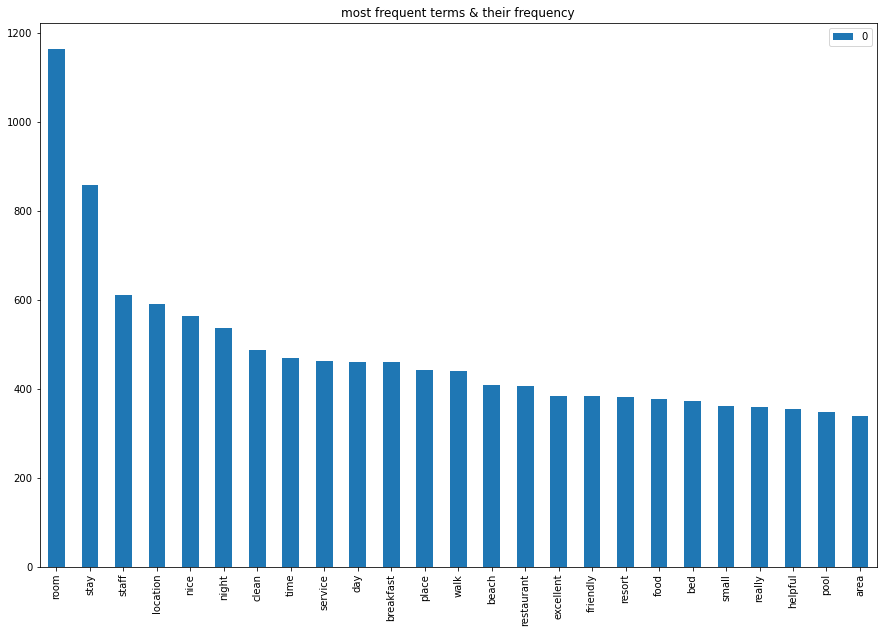

In [46]:
most_freq_terms.plot(kind='bar',
                     title='most frequent terms & their frequency',
                     figsize=(15, 10))

In [47]:
tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(2, 2))
tfidf2_x = tfidf2.fit_transform(data['lemma_str'])
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)

C:\Users\Shriprada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Bi-Gram'}>

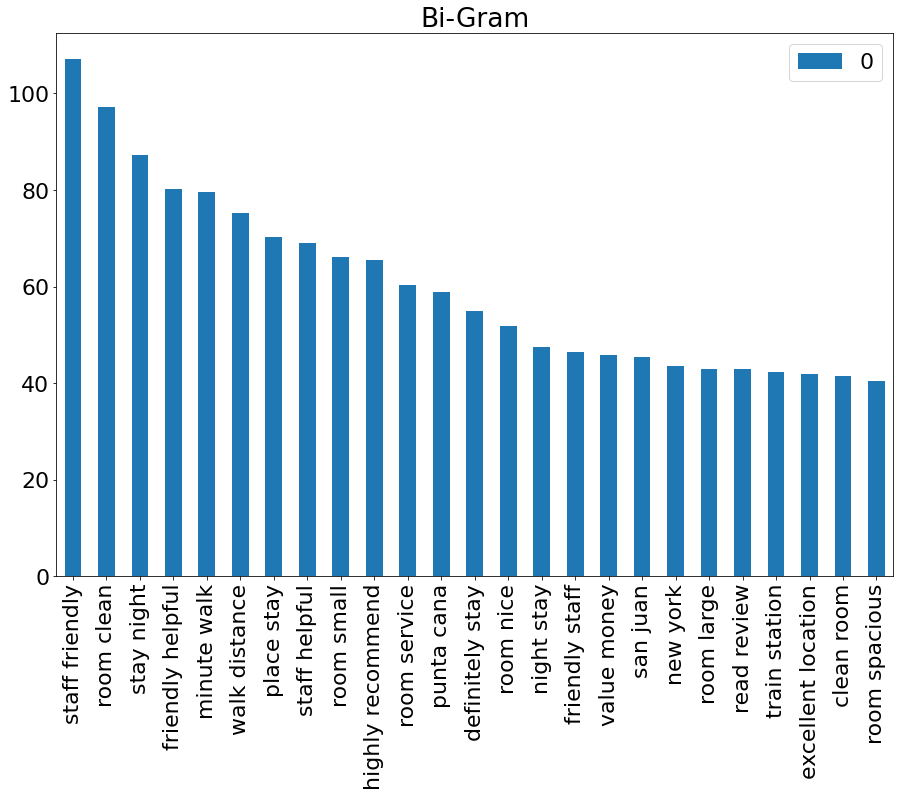

In [48]:
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Bi-Gram', figsize=(15, 10))

In [49]:
tfidf2 = TfidfVectorizer(norm="l2",
                         analyzer='word',
                         stop_words=stop_words_keywords,
                         ngram_range=(3, 3))
tfidf2_x = tfidf2.fit_transform(data['lemma_str'])
most_freq_terms = pd.DataFrame(
    tfidf2_x.sum(axis=0),
    columns=tfidf2.get_feature_names()).T.sort_values(0,
                                                      ascending=False).head(25)

C:\Users\Shriprada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Tri-Gram'}>

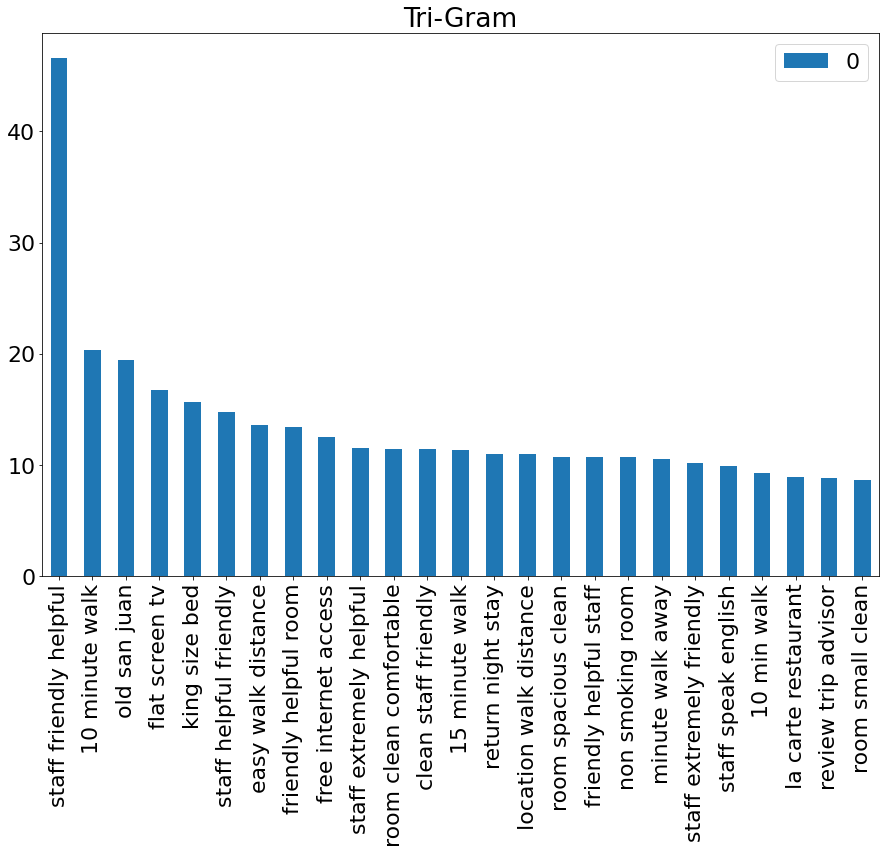

In [50]:
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Tri-Gram', figsize=(15, 10))

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

cv2 = CountVectorizer(stop_words=stop_words_keywords,ngram_range=(1,2))
cv2_x = cv2.fit_transform(data['lemma_str'])
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(cv2_x)

# get feature names
feature_names = cv2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = data['lemma_str'][532]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv2.transform([doc]))

C:\Users\Shriprada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [52]:
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
brilliant hotel wonderful staff funky interior arrive 6 day trip barcelona day hotel clean new excellent friendy staff speak highly hotel favourite level spend night drink terrece look light city.barcelona offer stay go barcelona soccor match amaze definatly worth visit spend day fab tour bus pay 20e day ticket 26e 2 day hop bus arounnd city fell love food market ramble main high street get smoothy 1 euro packet fruit 1 euro morning breakfast evening meal usually dearer 12e starter main desert look special offer meal display door restaurant total barcelona fab city art bulidings history food beautiful clean beach soft fluffy sand highly recocommend

Keywords:
barcelona 0.158
fab 0.107
usually dearer 0.097
total barcelona 0.097
ticket 26e 0.097
terrece look 0.097
street smoothy 0.097
soccor match 0.097
soccor 0.097
smoothy euro 0.097


In [53]:
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(1,2))
tfidf2_x = tfidf2.fit_transform(data['lemma_str'])
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(tfidf2_x)

# get feature names
feature_names = tfidf2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = data['lemma_str'][532]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(tfidf2.transform([doc]))

In [54]:
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
brilliant hotel wonderful staff funky interior arrive 6 day trip barcelona day hotel clean new excellent friendy staff speak highly hotel favourite level spend night drink terrece look light city.barcelona offer stay go barcelona soccor match amaze definatly worth visit spend day fab tour bus pay 20e day ticket 26e 2 day hop bus arounnd city fell love food market ramble main high street get smoothy 1 euro packet fruit 1 euro morning breakfast evening meal usually dearer 12e starter main desert look special offer meal display door restaurant total barcelona fab city art bulidings history food beautiful clean beach soft fluffy sand highly recocommend

Keywords:
usually dearer 0.112
total barcelona 0.112
ticket 26e 0.112
terrece look 0.112
street smoothy 0.112
soccor match 0.112
soccor 0.112
smoothy euro 0.112
sand highly 0.112
recocommend 0.112


In [55]:
tfidf = TfidfVectorizer(max_features=3000,
                       ngram_range=(1,3))
# TFIDF for X-train
review_tfidf= tfidf.fit_transform(data['lemma_str'])


In [56]:
X = review_tfidf
y = data['Affin_sentiment']

C:\Users\Shriprada\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Affin_sentiment', ylabel='count'>

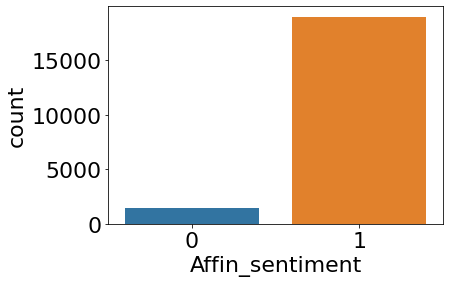

In [57]:
sns.countplot(y)

In [58]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

stregegy = 0.8

# initializing of SMOTEN Sampling
over = SMOTE(sampling_strategy= stregegy,random_state=7)

In [59]:
X_over, y_over = over.fit_resample(X, y)

C:\Users\Shriprada\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Affin_sentiment', ylabel='count'>

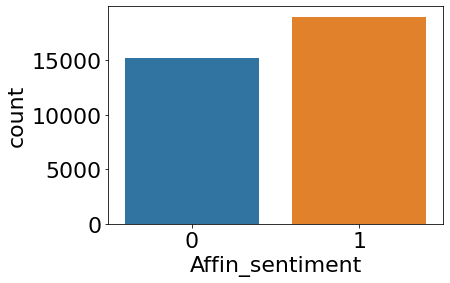

In [60]:
sns.countplot(y_over)

In [61]:
df = data[['lemma_str', 'Affin_sentiment']]

In [62]:
df.to_csv('review.csv')